<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [2]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 825, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 825 (delta 105), reused 27 (delta 27), pack-reused 649 (from 4)
Receiving objects: 100% (825/825), 95.07 MiB | 8.23 MiB/s, done.
Resolving deltas: 100% (431/431), done.
Updating files: 100% (26/26), done.
/content/DATCapstone/data


In [3]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [4]:
df

Date        Open        High         Low       Close    Volume  \
149  2021-09-30  140.983670  141.690258  138.648004  138.863907  89056700   
152  2021-10-01  139.256450  140.257452  136.518433  139.992477  94639600   
155  2021-10-04  139.119037  139.560665  135.694064  136.547852  98322000   
158  2021-10-05  136.891371  139.590139  136.763788  138.481186  80861100   
161  2021-10-06  136.871718  139.501783  135.792205  139.354584  83221100   
...         ...         ...         ...         ...         ...       ...   
8062 2025-01-27  394.799988  406.690002  389.000000  397.149994  58125500   
8072 2025-01-28  396.910004  400.589996  386.500000  398.089996  48910700   
8082 2025-01-29  395.209991  398.589996  384.480011  389.100006  68033600   
8092 2025-01-30  410.779999  412.500000  384.410004  400.279999  98092900   
8102 2025-01-31  401.529999  419.989990  401.339996  404.600006  83568200   

      Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
149         0.0           0.0           23921.991                    4.7  ...   
152         0.0           0.0           24777.038                    4.5  ...   
155         0.0           0.0           24777.038                    4.5  ...   
158         0.0           0.0           24777.038                    4.5  ...   
161         0.0           0.0           24777.038                    4.5  ...   
...         ...           ...                 ...                    ...  ...   
8062        0.0           0.0           29723.864                    4.0  ...   
8072        0.0           0.0           29723.864                    4.0  ...   
8082        0.0           0.0           29723.864                    4.0  ...   
8092        0.0           0.0           29723.864                    4.0  ...   
8102        0.0           0.0           29723.864                    4.0  ...   

       emb_763   emb_764   emb_765   emb_766   emb_767  Target_1day  \
149        NaN       NaN       NaN       NaN       NaN     1.128571   
152        NaN       NaN       NaN       NaN       NaN    -3.444626   
155        NaN       NaN       NaN       NaN       NaN     1.933334   
158        NaN       NaN       NaN       NaN       NaN     0.873398   
161        NaN       NaN       NaN       NaN       NaN     1.265976   
...        ...       ...       ...       ...       ...          ...   
8062  1.174326 -0.262426  0.298183  0.182200  0.388200     0.940002   
8072  0.084330 -0.354550 -0.611864 -0.449780  0.584349    -8.989990   
8082  0.827862 -0.620100 -0.024186 -0.439615  0.781107    11.179993   
8092  1.383147 -0.616897 -0.145329 -0.418483  0.636253     4.320007   
8102  0.658588 -0.312093 -0.158066 -0.211410  0.834208          NaN   

      Target_1week  Target_1month  Target_1year  Ticker  
149       1.756653      10.863785      9.008606    AAPL  
152       0.245331       7.016815      0.616699    AAPL  
155       3.601639       9.637100     -0.162491    AAPL  
158       0.392532       8.744034      2.098389    AAPL  
161      -1.069687       9.313263      4.827057    AAPL  
...            ...            ...           ...     ...  
8062           NaN            NaN           NaN    TSLA  
8072           NaN            NaN           NaN    TSLA  
8082           NaN            NaN           NaN    TSLA  
8092           NaN            NaN           NaN    TSLA  
8102           NaN            NaN           NaN    TSLA  

[8103 rows x 817 columns]

In [5]:
!pip install tensorflow


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Fill missing values
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)

# Sequence creation
def create_sequences_labeled(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i - look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Main training & evaluation function
def run_lstm_by_ticker(df, ticker, target, look_back=30, epochs=20, batch_size=32):
    df_ticker = df[df['Ticker'] == ticker].copy().sort_values(by='Date')
    df_ticker = df_ticker.dropna(subset=[target])


    feature_cols = [col for col in df_ticker.columns if 'Target' not in col and col not in ['Date', 'Ticker']]
    df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

    X = df_ticker[feature_cols].values
    y = df_ticker[target].values

    if len(X) <= look_back + 30:
        print(f"[{ticker}] {target}: Not enough data. Skipping.")
        return

    X_seq, y_seq = create_sequences_labeled(X, y, look_back)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

    # Create sequences
    nsamples, nsteps, nfeatures = X_train.shape
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, nfeatures)).reshape(nsamples, nsteps, nfeatures)

    nsamples_val = X_val.shape[0]
    X_val_scaled = scaler.transform(X_val.reshape(-1, nfeatures)).reshape(nsamples_val, nsteps, nfeatures)

    nsamples_test = X_test.shape[0]
    X_test_scaled = scaler.transform(X_test.reshape(-1, nfeatures)).reshape(nsamples_test, nsteps, nfeatures)

    X_train_seq = X_train_scaled
    y_train_seq = y_train
    X_val_seq = X_val_scaled
    y_val_seq = y_val
    X_test_seq = X_test_scaled
    y_test_seq = y_test


    # Define and train model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop],
        verbose=0
    )

    # Predict and evaluate
    y_pred = model.predict(X_test_seq).flatten()
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)

    print(f"\n[{ticker}] Target: {target}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_seq, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"LSTM Prediction – {ticker} | {target}")
    plt.xlabel('Sample Index')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save only MSFT plots
    if ticker == 'MSFT':
        filename = f'msft_lstm_{target}.png'
        plt.savefig(filename)

    plt.show()

    return history


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step

[MSFT] Target: Target_1day
MAE : 14.7525
RMSE: 17.0074
R²   : -15.5922


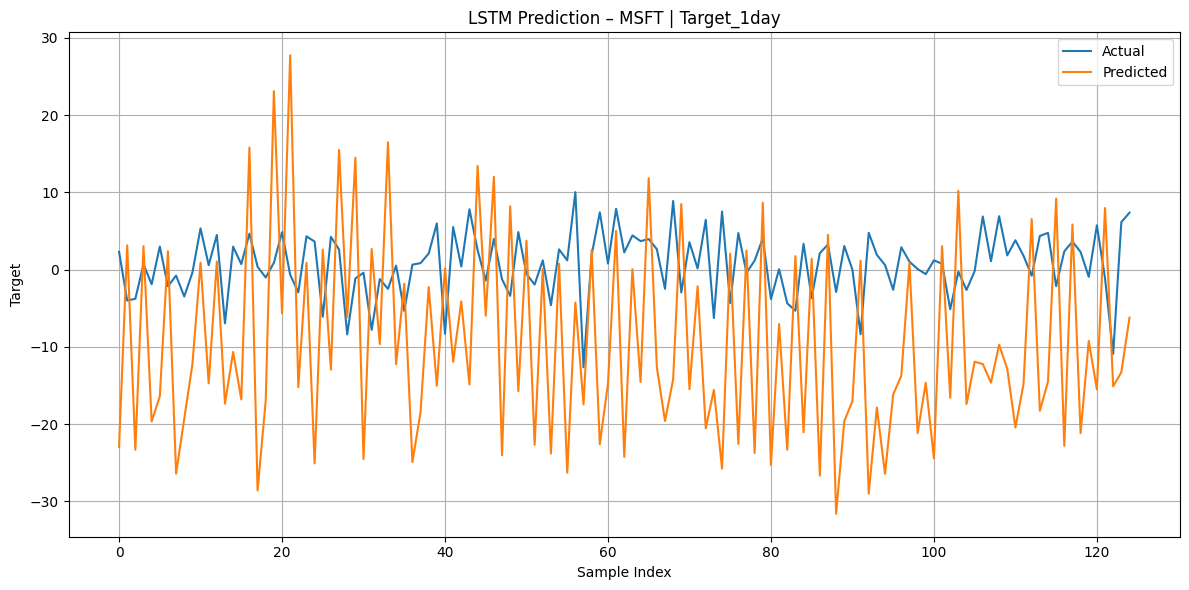

Epoch 1: Train Loss = 30.1525 | Validation Loss = 115.6709
Epoch 2: Train Loss = 29.1237 | Validation Loss = 146.8125
Epoch 3: Train Loss = 25.1777 | Validation Loss = 181.7945
Epoch 4: Train Loss = 23.0112 | Validation Loss = 127.3764


In [7]:
# Validation 성능 확인용
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1day')

# history가 제대로 반환되었는지 확인
if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step

[MSFT] Target: Target_1week
MAE : 7.7916
RMSE: 10.0912
R²   : -0.4881


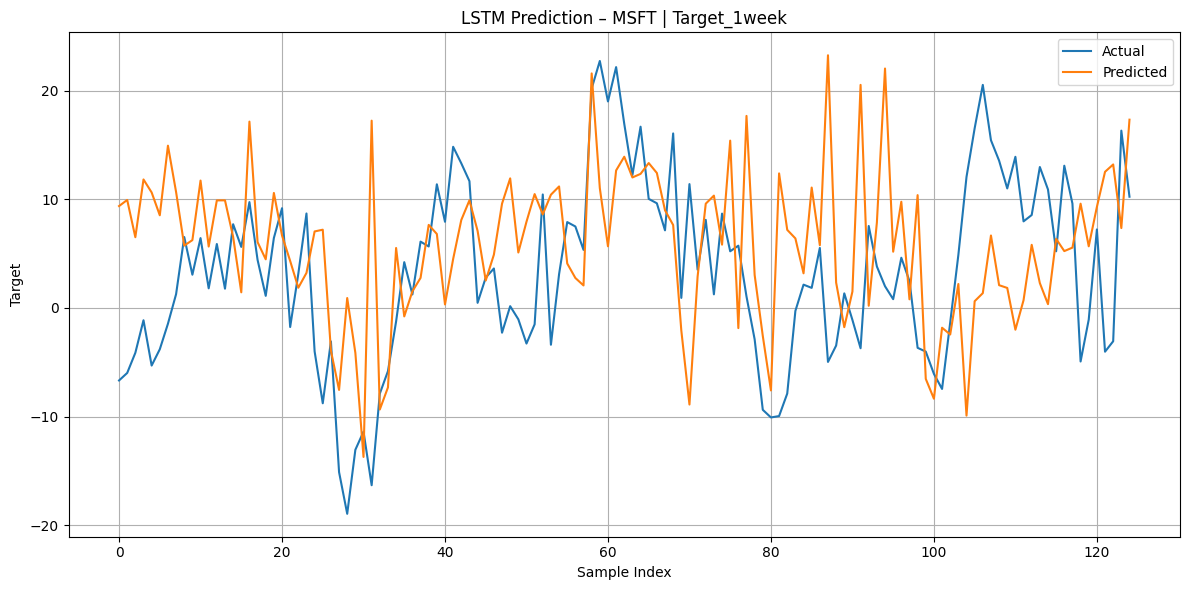

Epoch 1: Train Loss = 125.9684 | Validation Loss = 233.1796
Epoch 2: Train Loss = 97.4798 | Validation Loss = 436.2570
Epoch 3: Train Loss = 82.2764 | Validation Loss = 244.9594
Epoch 4: Train Loss = 76.4492 | Validation Loss = 349.6842


In [8]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1week')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

[MSFT] Target: Target_1month
MAE : 76.2730
RMSE: 91.5344
R²   : -28.7054


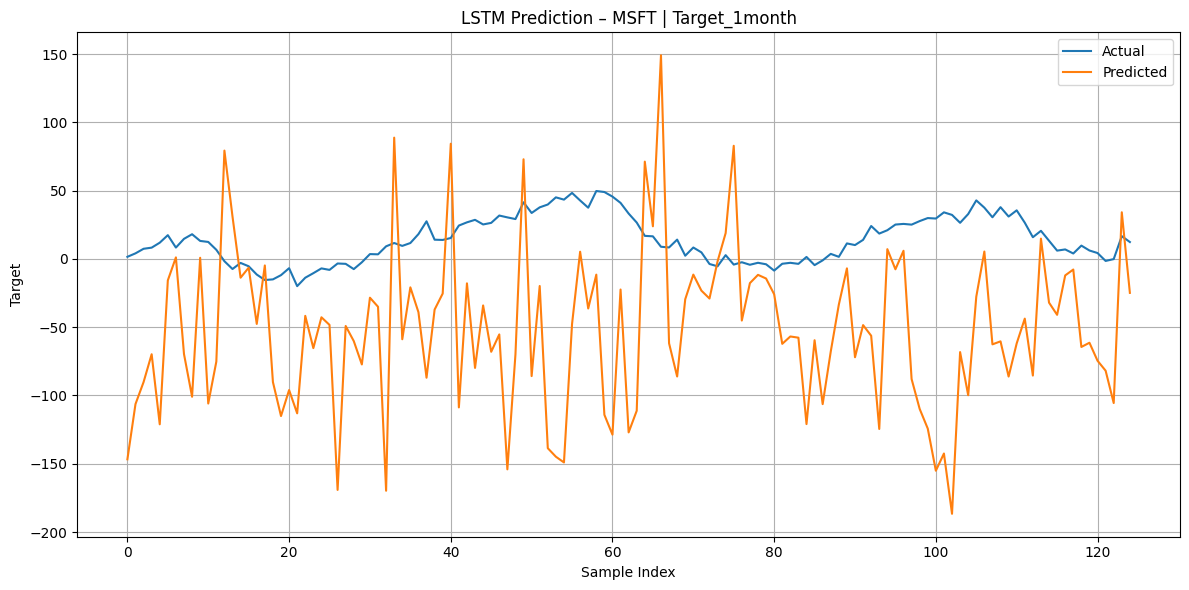

Epoch 1: Train Loss = 349.5022 | Validation Loss = 6940.1719
Epoch 2: Train Loss = 217.8436 | Validation Loss = 4924.3086
Epoch 3: Train Loss = 182.0799 | Validation Loss = 5149.7114
Epoch 4: Train Loss = 111.1112 | Validation Loss = 4418.4331
Epoch 5: Train Loss = 81.4132 | Validation Loss = 2535.8528
Epoch 6: Train Loss = 73.4783 | Validation Loss = 2328.2520
Epoch 7: Train Loss = 56.6484 | Validation Loss = 2385.1328
Epoch 8: Train Loss = 60.8437 | Validation Loss = 2529.9717
Epoch 9: Train Loss = 49.9892 | Validation Loss = 2826.4641


In [9]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1month')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

[MSFT] Target: Target_1year
MAE : 280.6303
RMSE: 357.0008
R²   : -203.6749


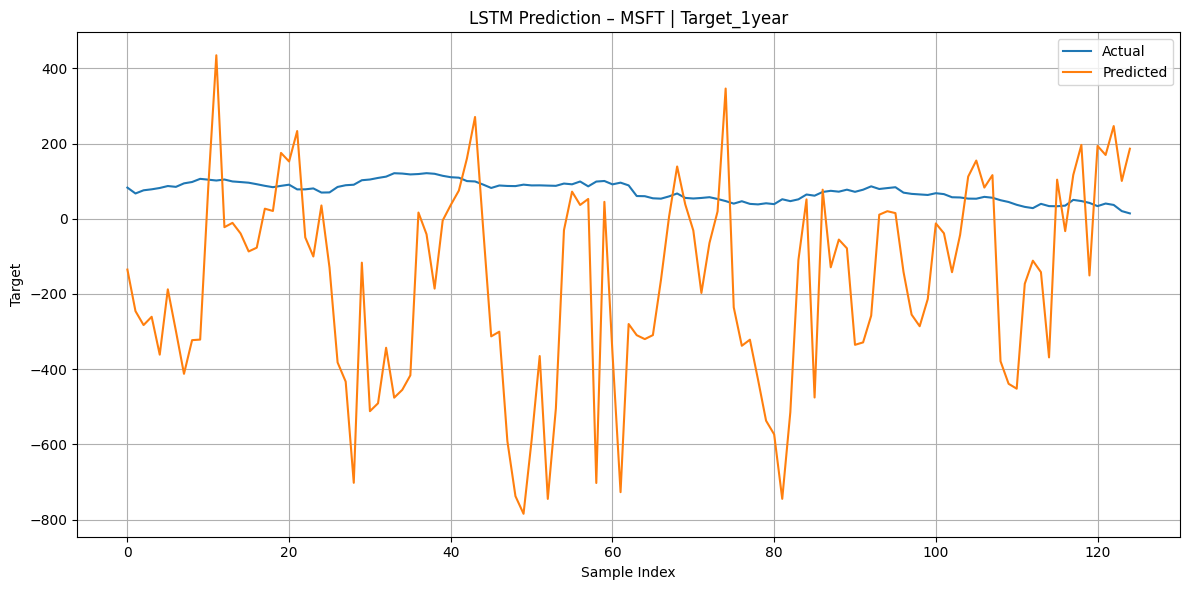

Epoch 1: Train Loss = 5838.1245 | Validation Loss = 16296.3477
Epoch 2: Train Loss = 3634.7444 | Validation Loss = 24735.4199
Epoch 3: Train Loss = 6115.0747 | Validation Loss = 24483.4453
Epoch 4: Train Loss = 7813.3647 | Validation Loss = 16408.7188


In [10]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1year')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


In [11]:
print("Date dtype:", df['Date'].dtype)
print("Ticker column exists:", 'Ticker' in df.columns)
print("Target columns:", [col for col in df.columns if 'Target' in col])
print("Missing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("Column types:")
print(df.dtypes.value_counts())


Date dtype: datetime64[ns]
Ticker column exists: True
Target columns: ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']
Missing values (top 10):
Ticker     0
emb_756    0
emb_755    0
emb_754    0
emb_753    0
emb_752    0
emb_751    0
emb_750    0
emb_749    0
emb_748    0
dtype: int64
Column types:
float64           814
datetime64[ns]      1
int64               1
object              1
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

[AAPL] Target: Target_1day
MAE : 4.6348
RMSE: 6.7213
R²   : -7.9045


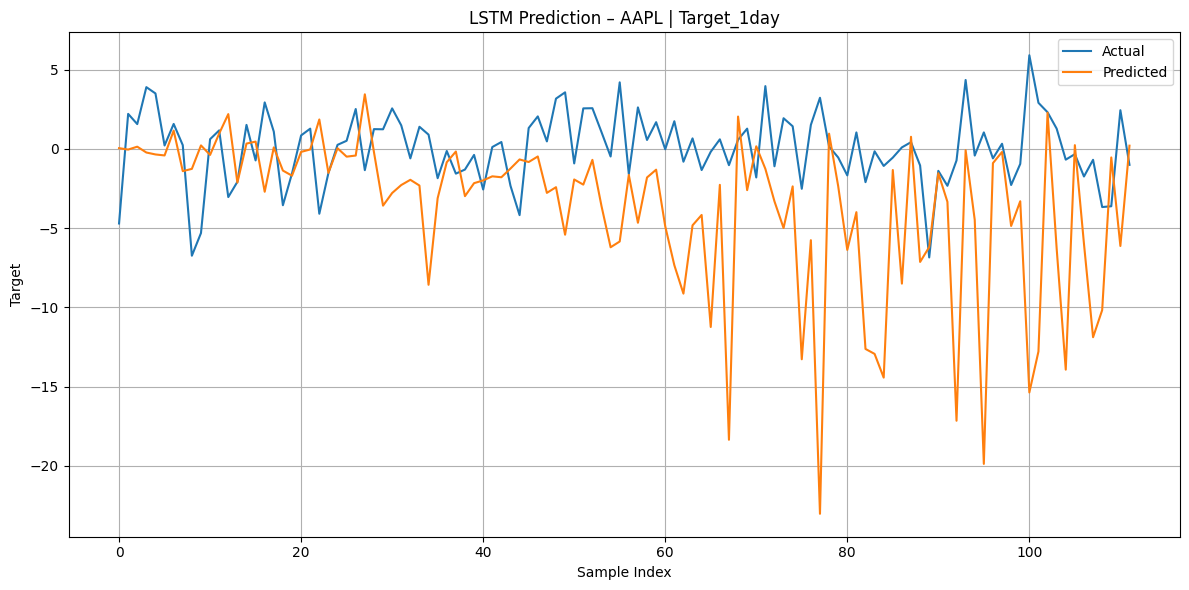

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step

[AAPL] Target: Target_1week
MAE : 6.0156
RMSE: 7.4527
R²   : -0.6657


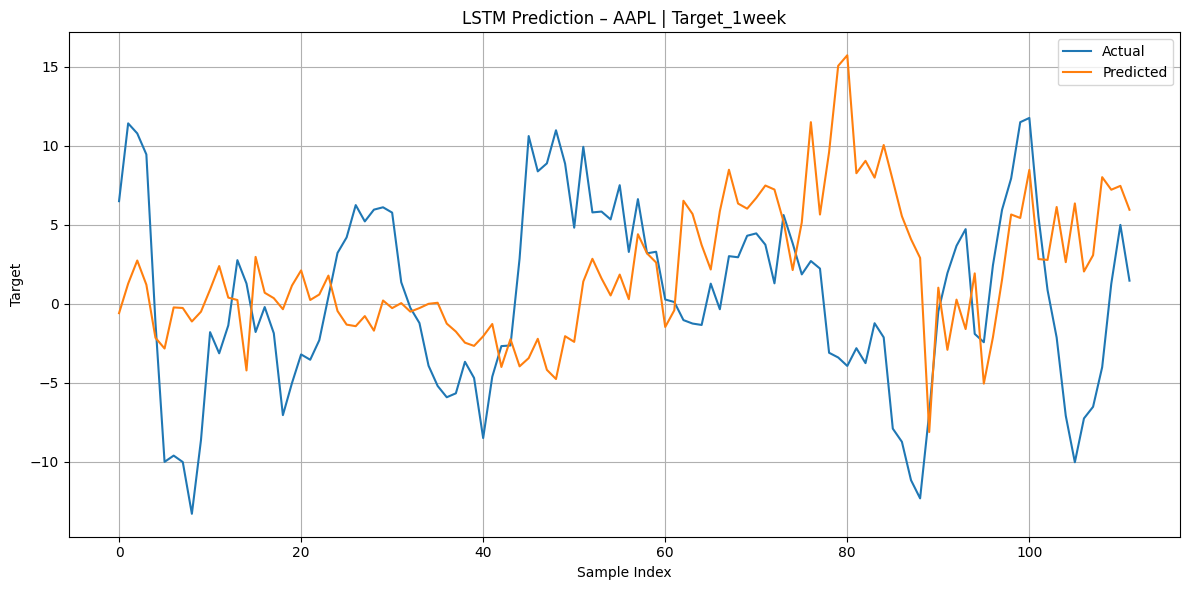

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step

[AAPL] Target: Target_1month
MAE : 9.8840
RMSE: 11.8379
R²   : -0.6630


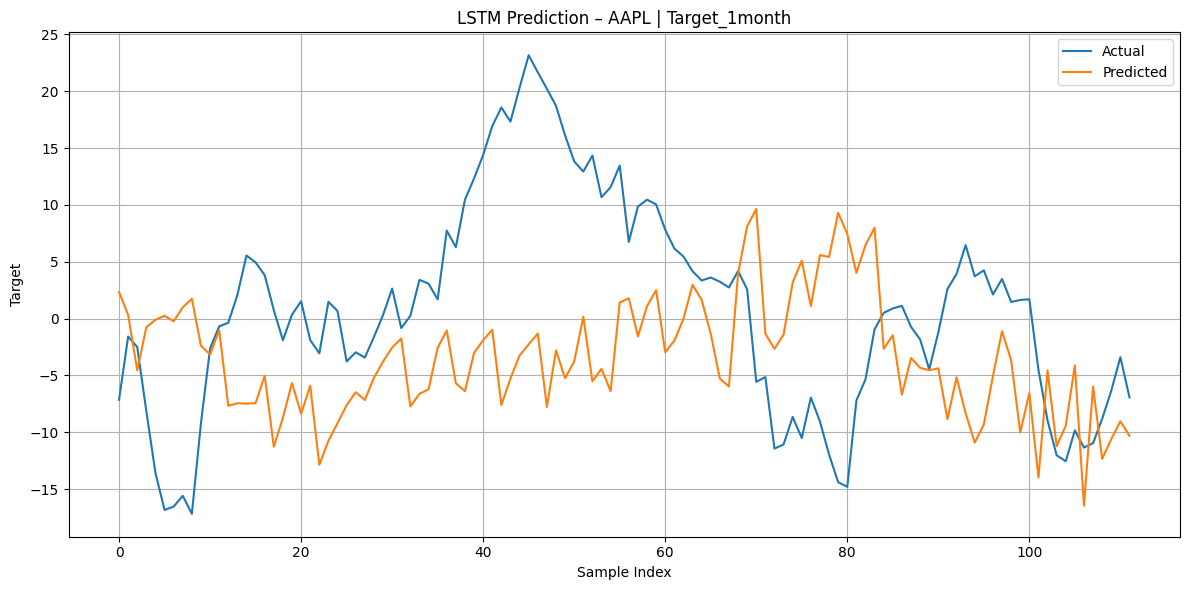

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

[AAPL] Target: Target_1year
MAE : 29.1527
RMSE: 31.1782
R²   : -10.7520


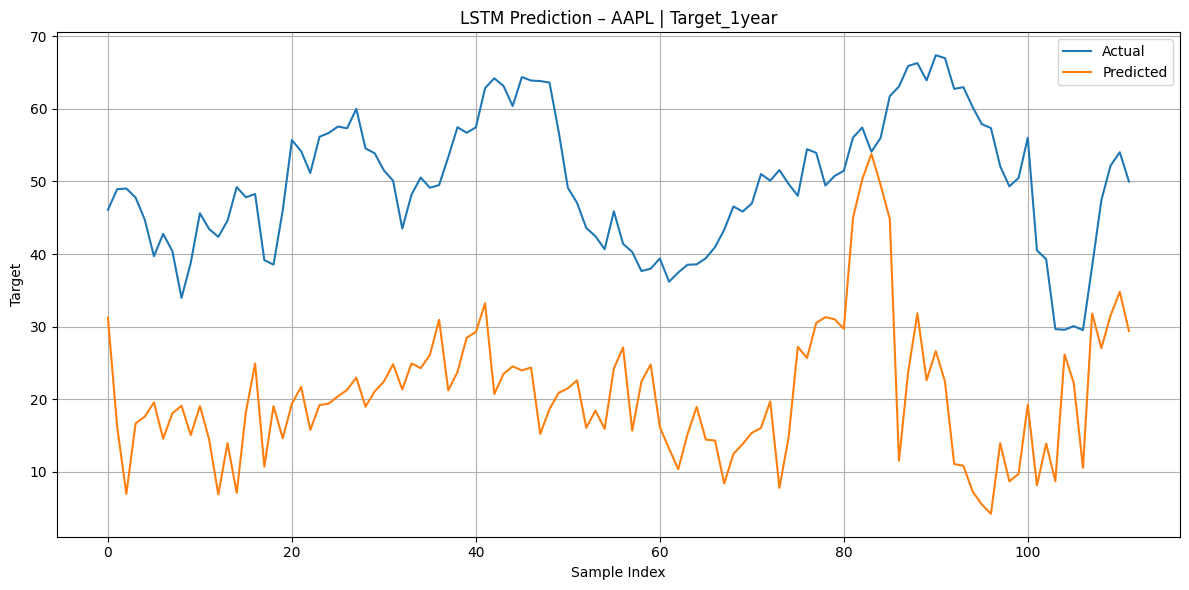

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AMD] Target: Target_1day
MAE : 4.2917
RMSE: 6.6697
R²   : -2.3103


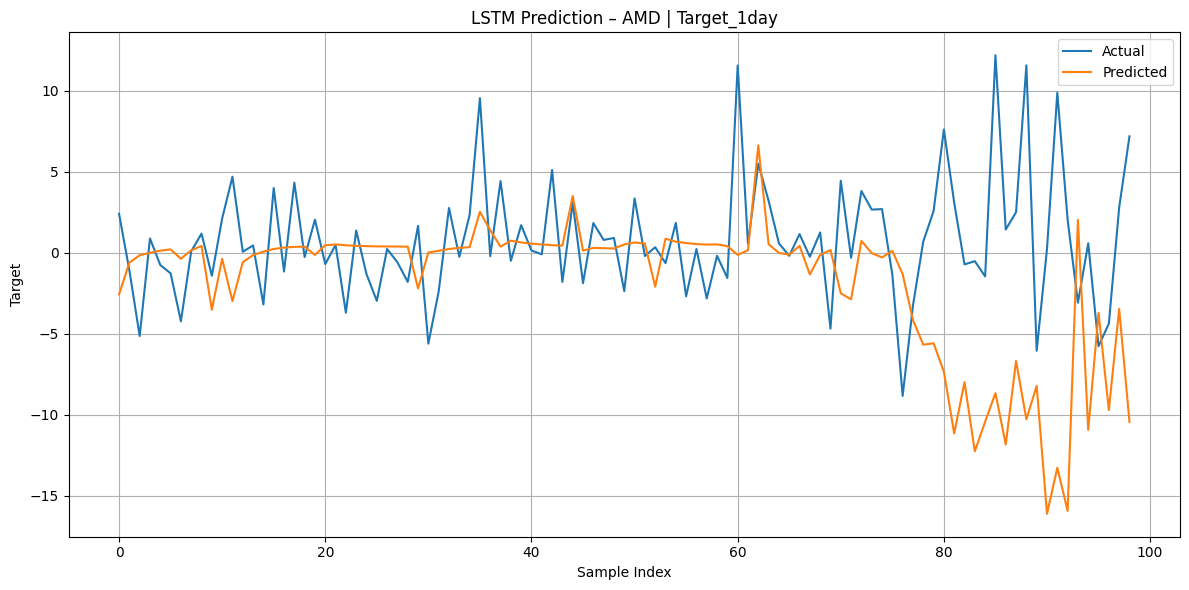

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

[AMD] Target: Target_1week
MAE : 14.8241
RMSE: 23.1948
R²   : -7.2468


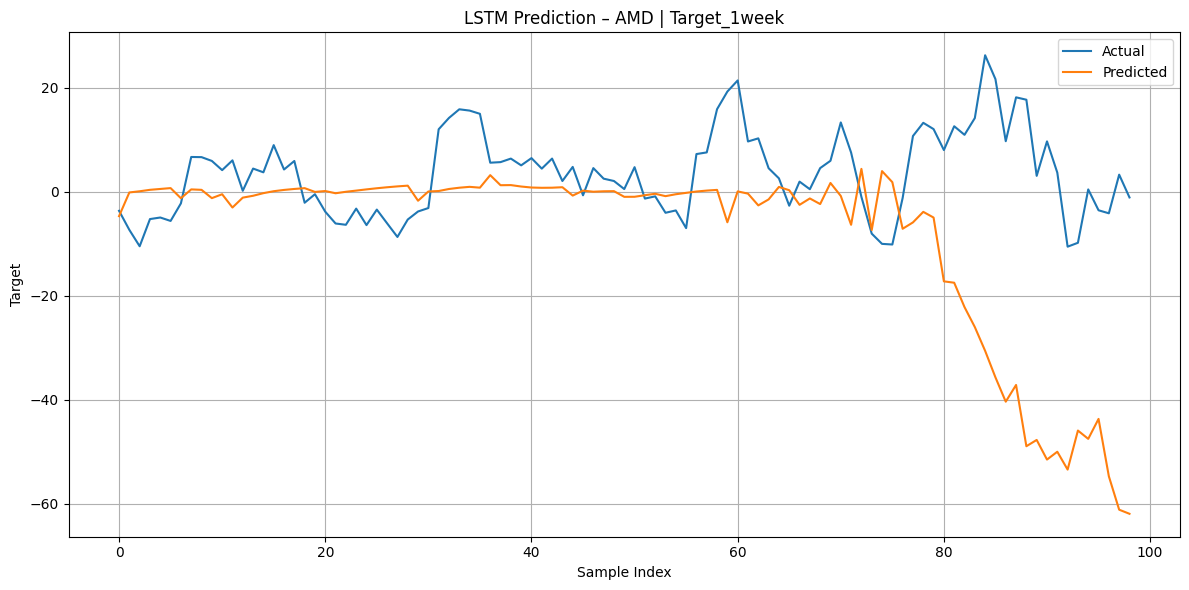

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

[AMD] Target: Target_1month
MAE : 14.1794
RMSE: 19.4882
R²   : -1.8874


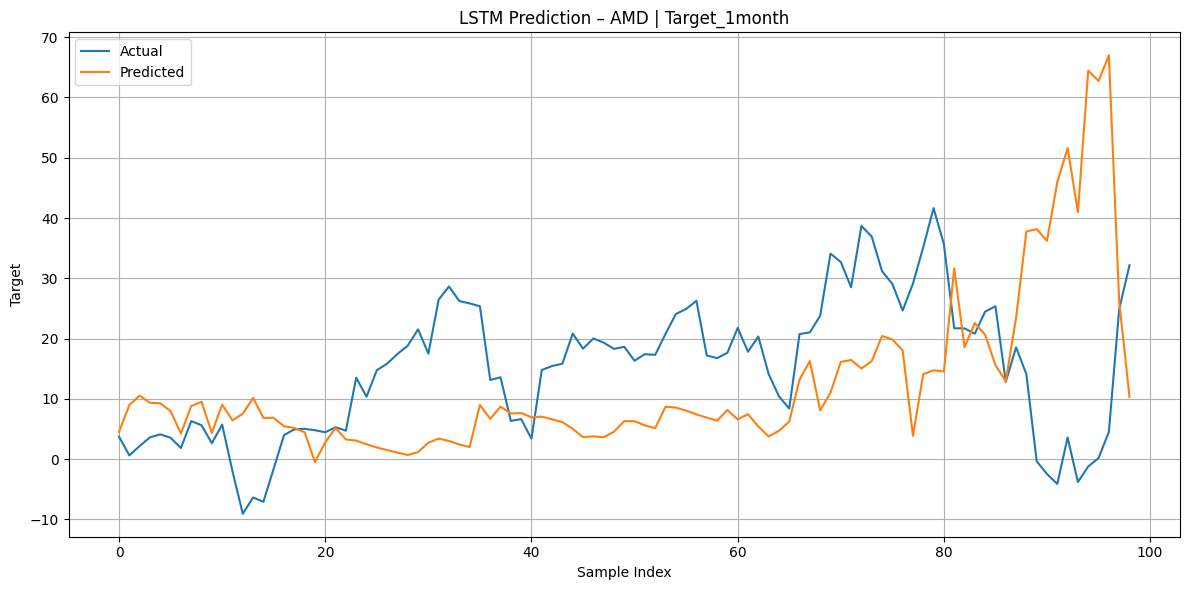

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

[AMD] Target: Target_1year
MAE : 31.1542
RMSE: 37.4086
R²   : 0.0836


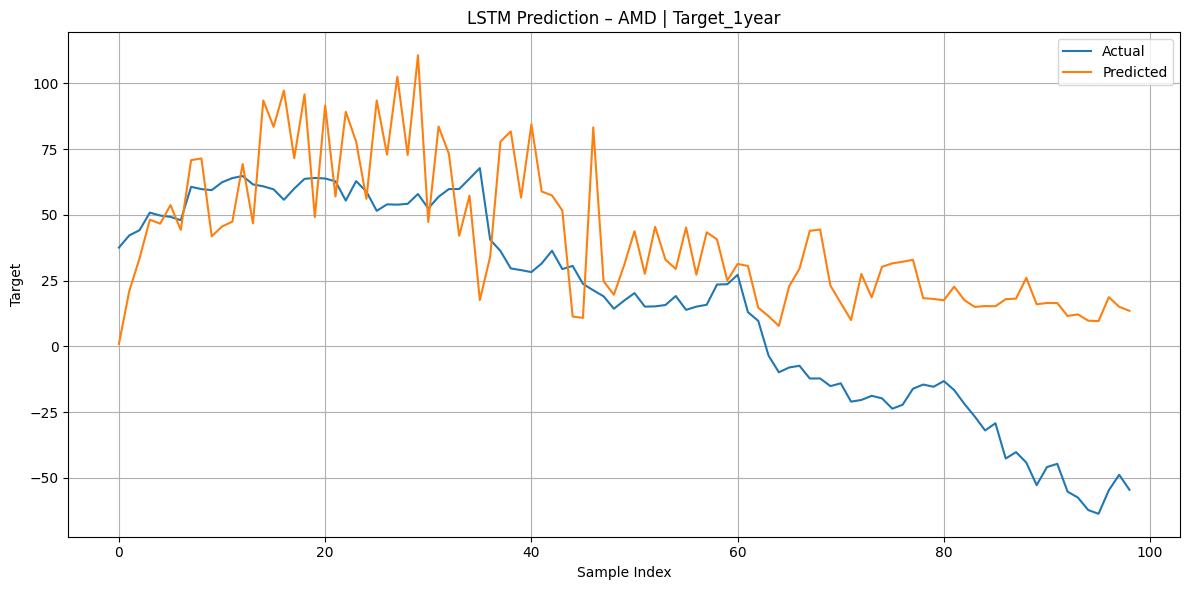

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

[AMZN] Target: Target_1day
MAE : 4.9671
RMSE: 8.3540
R²   : -8.3302


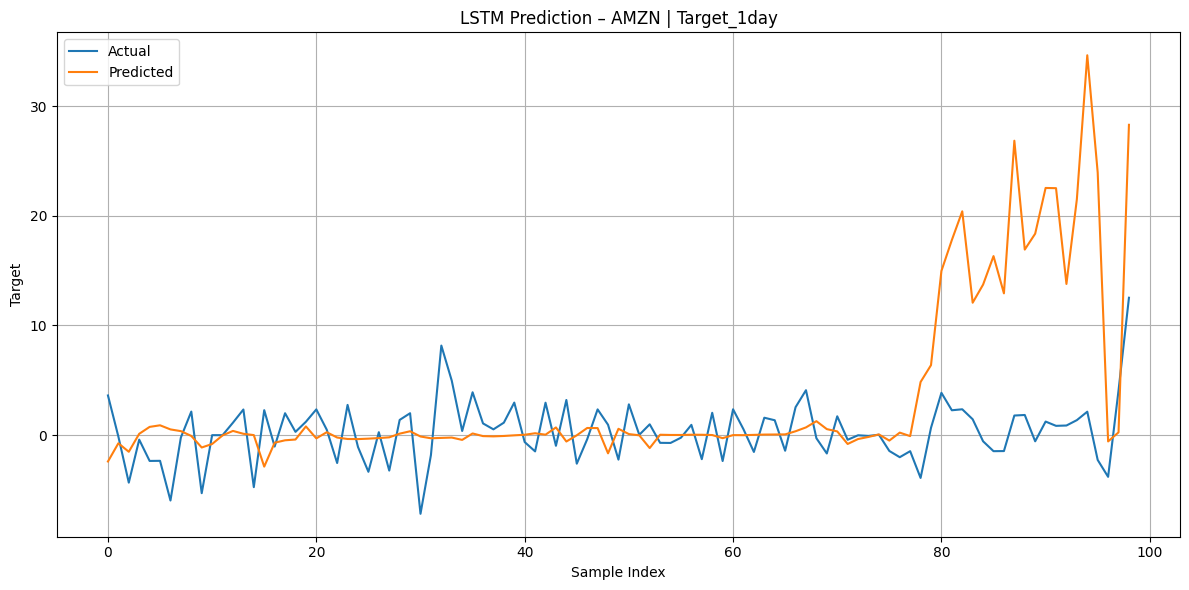

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

[AMZN] Target: Target_1week
MAE : 6.8190
RMSE: 9.6457
R²   : -1.6787


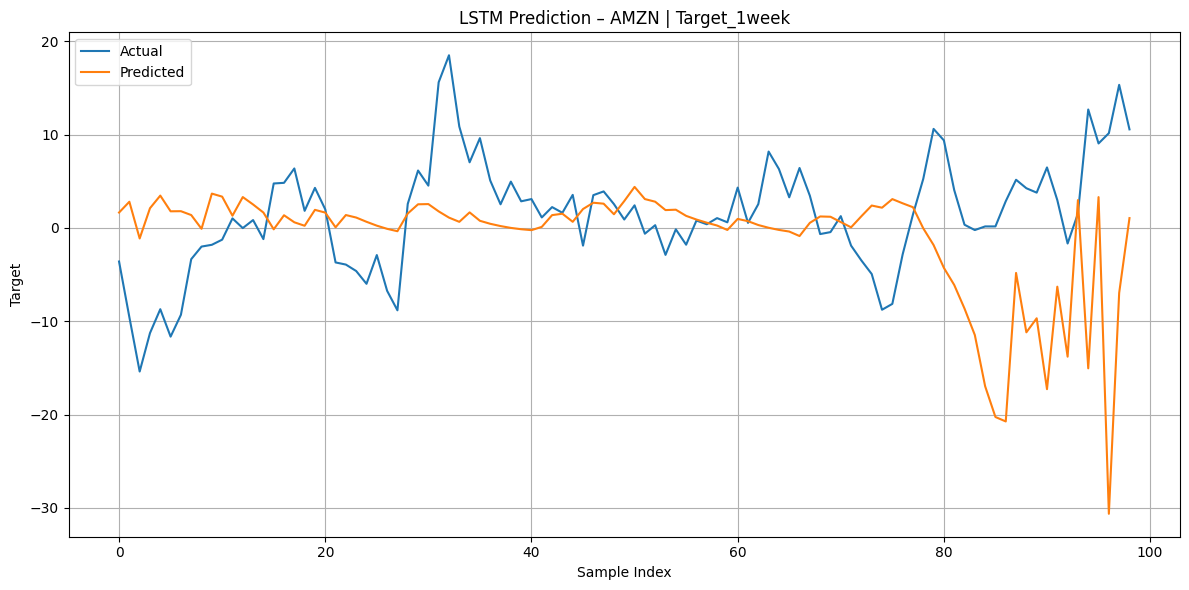

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

[AMZN] Target: Target_1month
MAE : 16.2826
RMSE: 19.0566
R²   : -3.8542


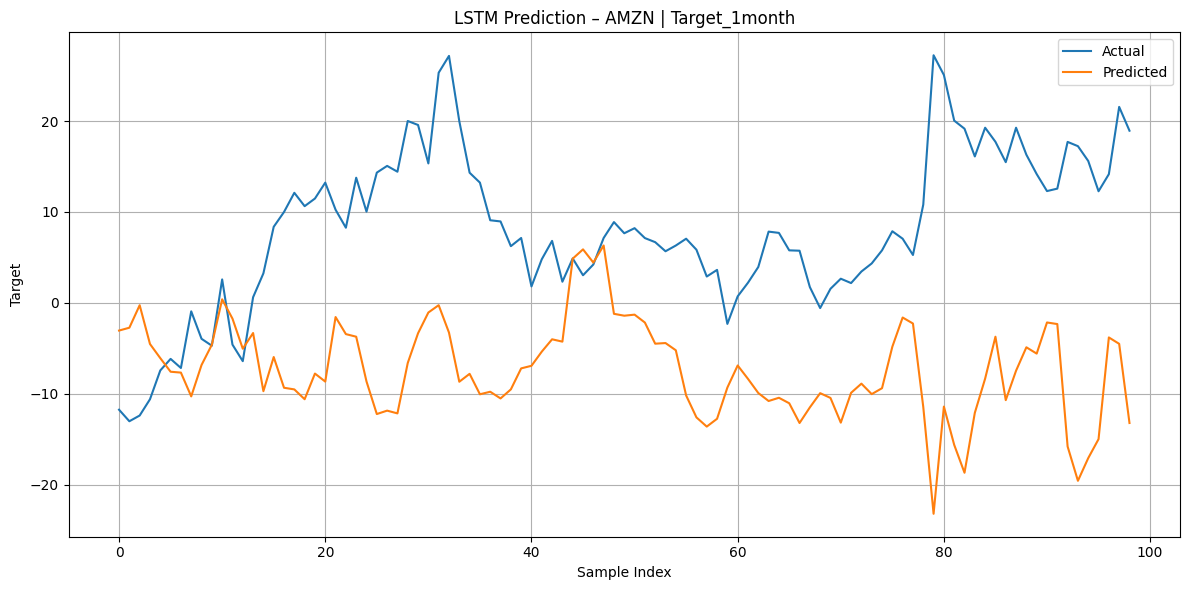

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

[AMZN] Target: Target_1year
MAE : 18.0315
RMSE: 25.9504
R²   : -5.5635


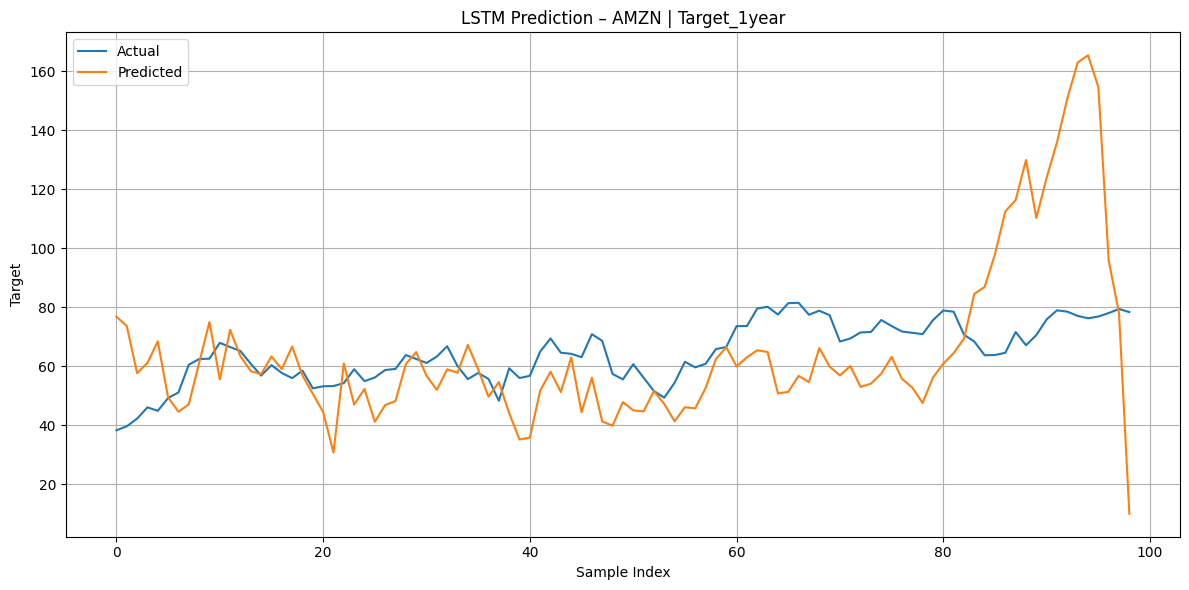

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

[AVGO] Target: Target_1day
MAE : 10.3192
RMSE: 19.1424
R²   : -92.2775


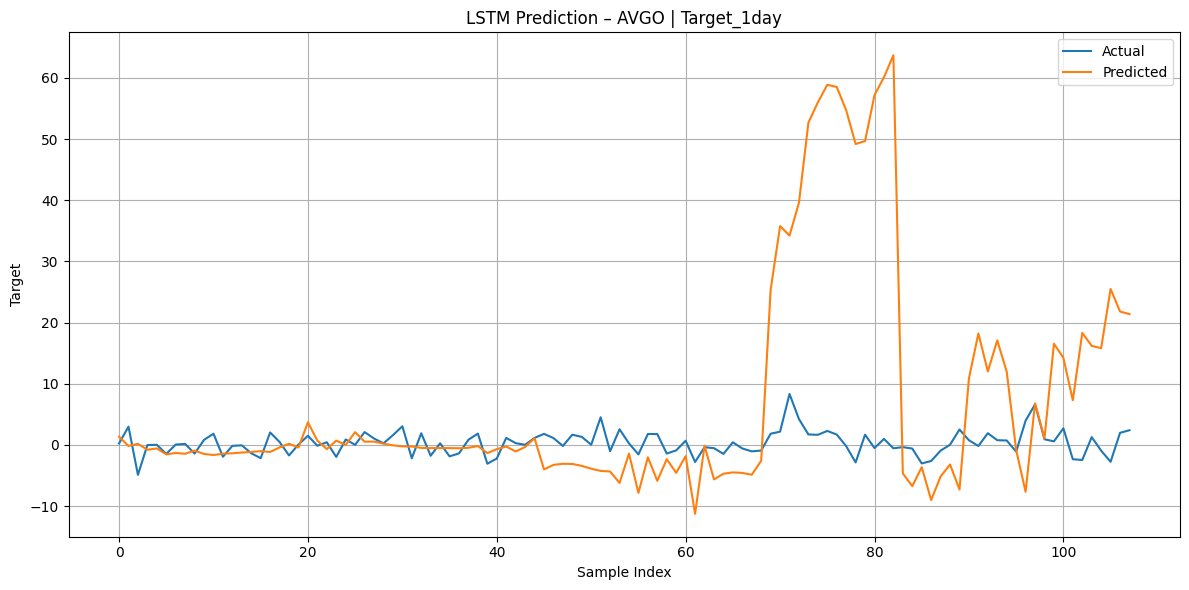

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

[AVGO] Target: Target_1week
MAE : 12.0955
RMSE: 18.6009
R²   : -10.4451


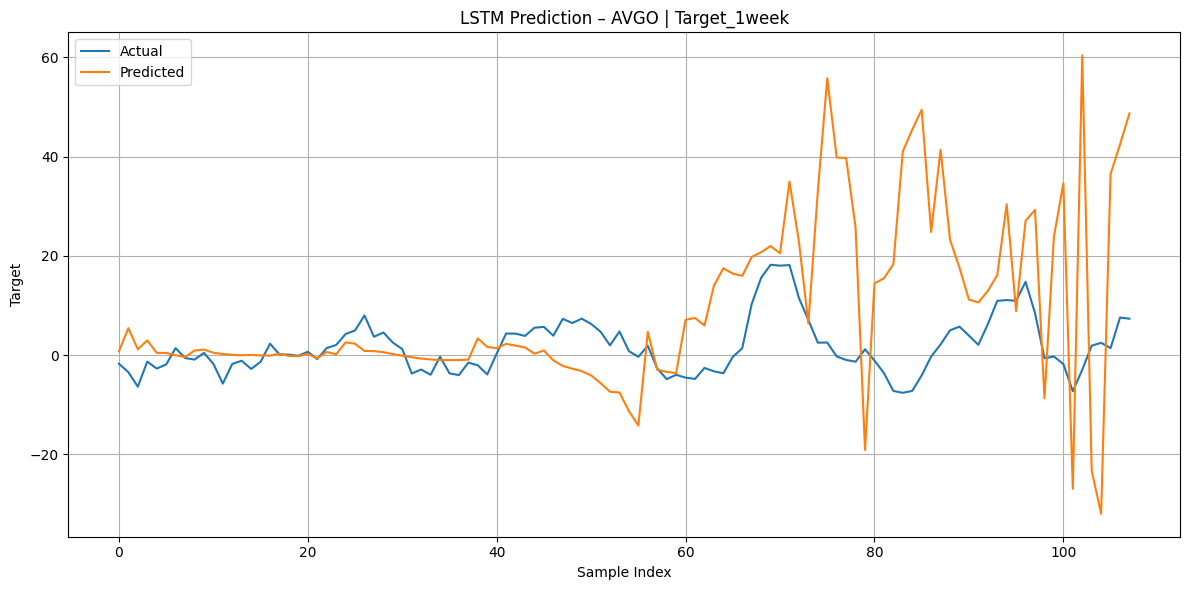

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

[AVGO] Target: Target_1month
MAE : 8.7707
RMSE: 10.3808
R²   : -1.4586


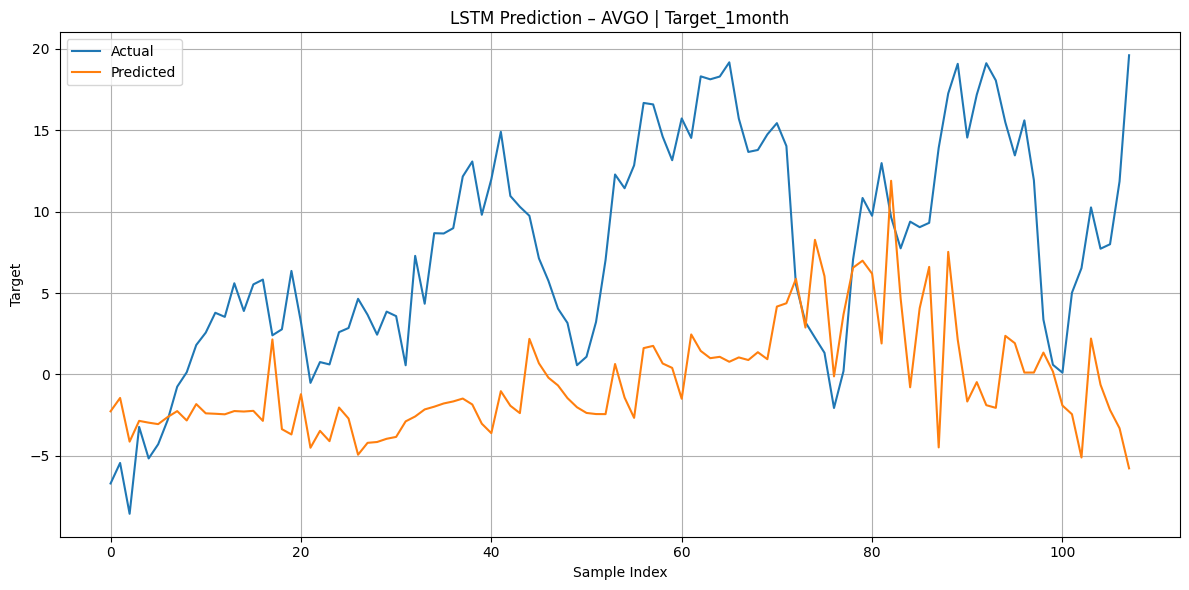

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step

[AVGO] Target: Target_1year
MAE : 72.4457
RMSE: 77.4670
R²   : -14.1691


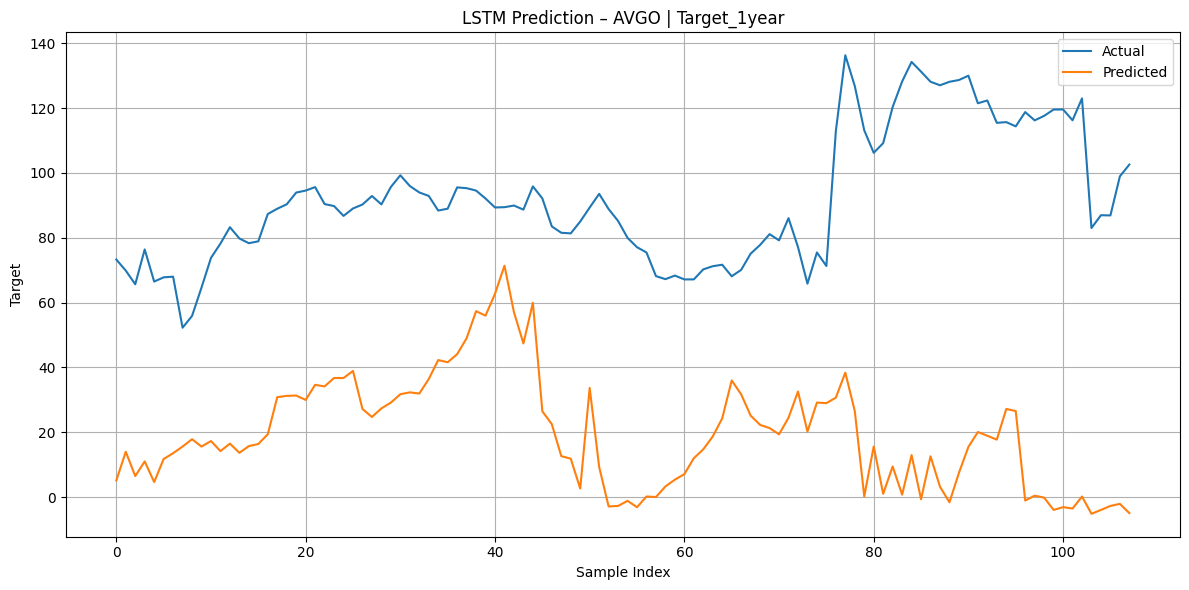

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

[GOOGL] Target: Target_1day
MAE : 7.1726
RMSE: 16.0637
R²   : -40.0839


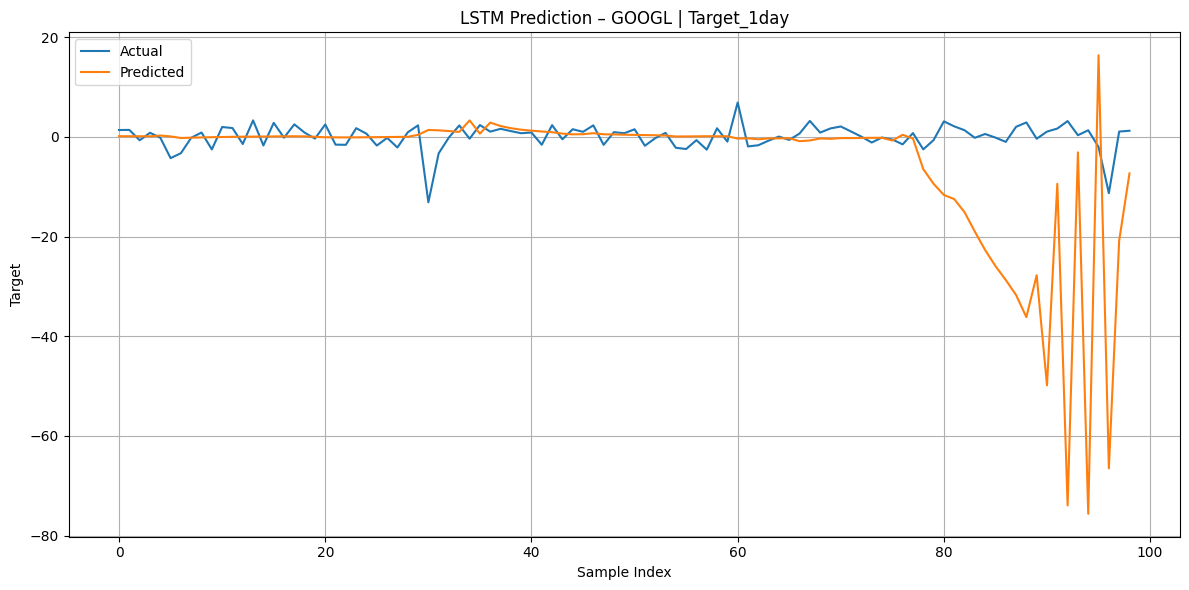

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

[GOOGL] Target: Target_1week
MAE : 16.8065
RMSE: 39.3829
R²   : -47.4897


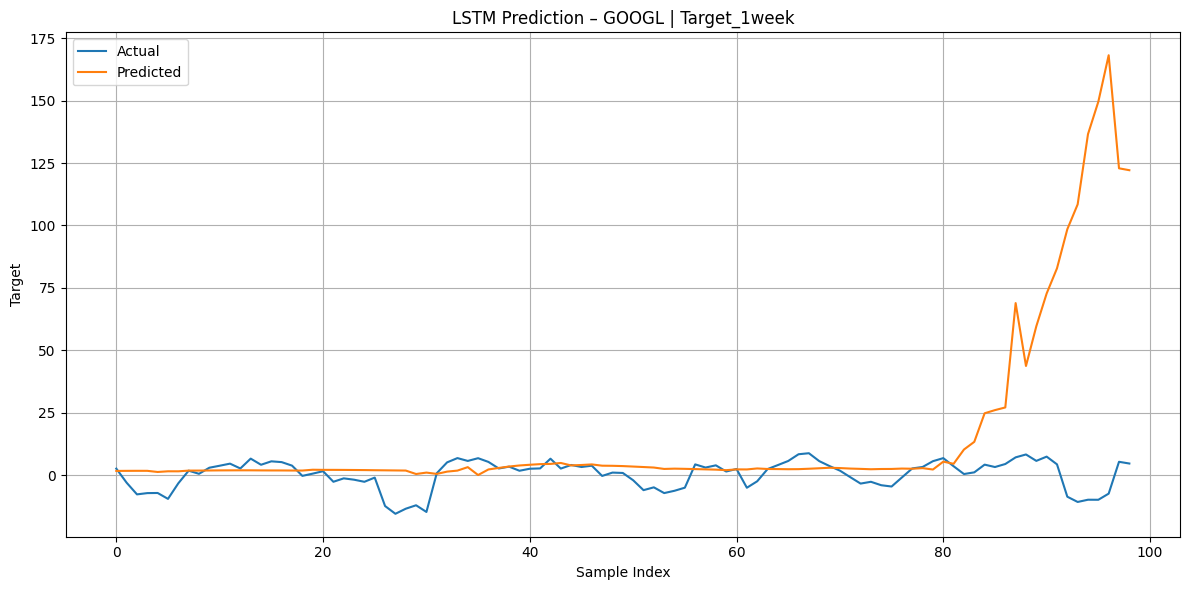

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

[GOOGL] Target: Target_1month
MAE : 11.0363
RMSE: 18.0098
R²   : -5.8292


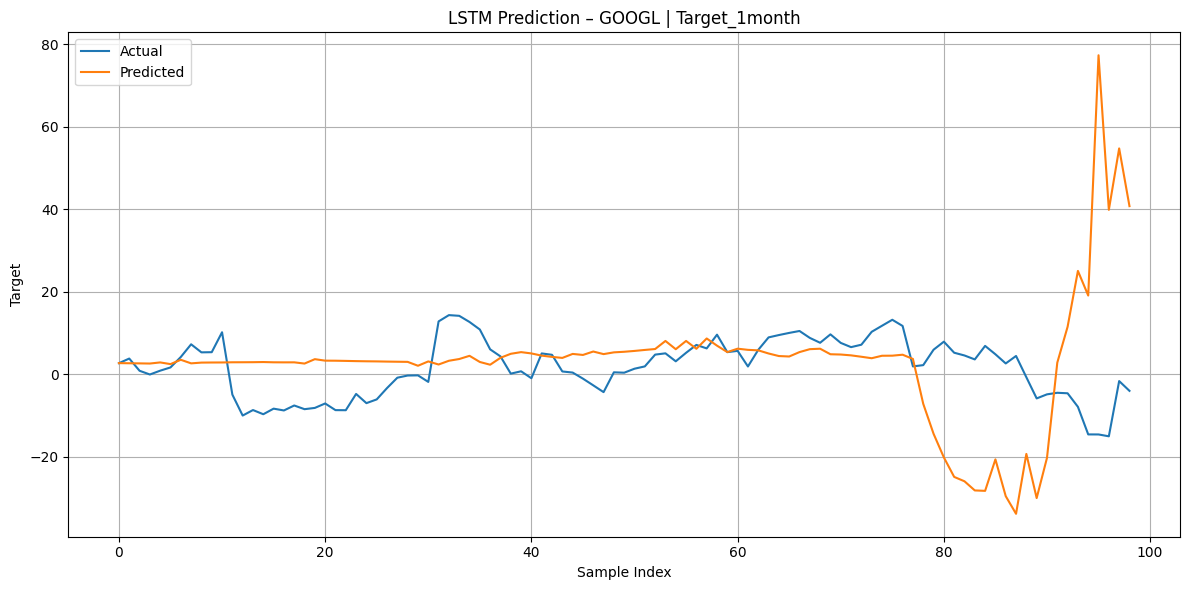

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

[GOOGL] Target: Target_1year
MAE : 69.8418
RMSE: 153.3923
R²   : -162.1557


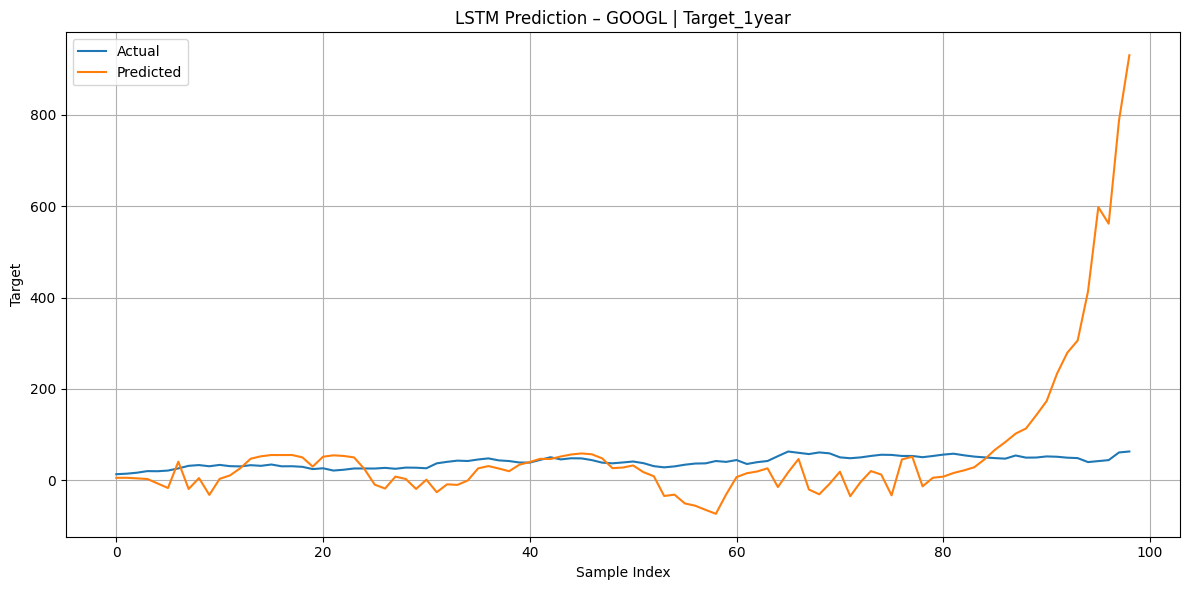

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

[META] Target: Target_1day
MAE : 5.7924
RMSE: 10.7208
R²   : -0.2736


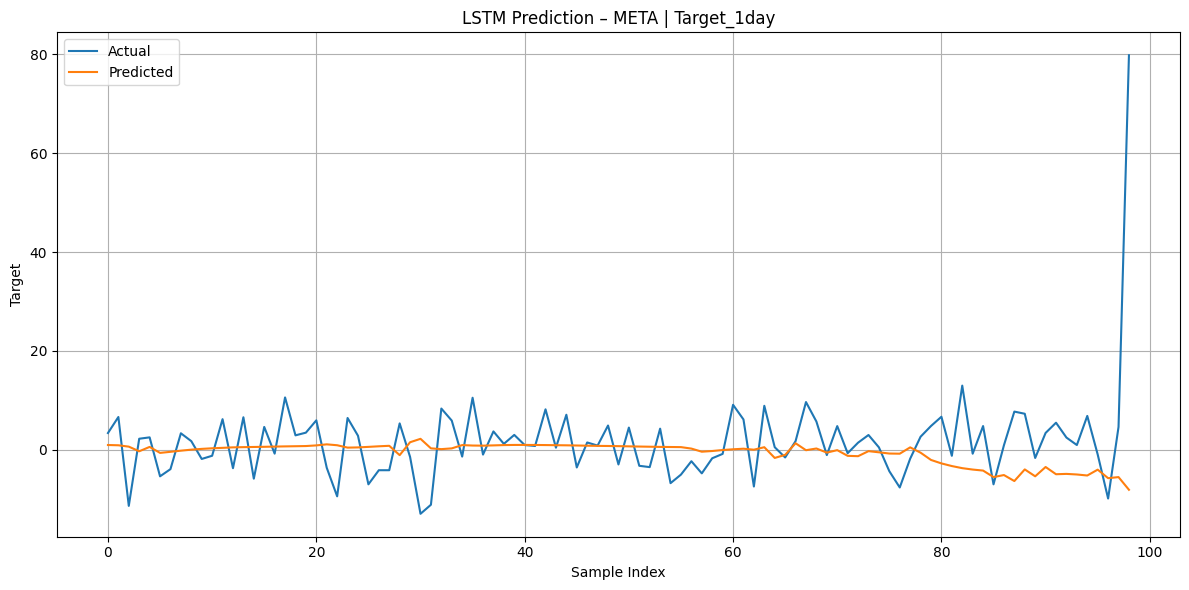

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

[META] Target: Target_1week
MAE : 13.4166
RMSE: 19.9668
R²   : -0.1910


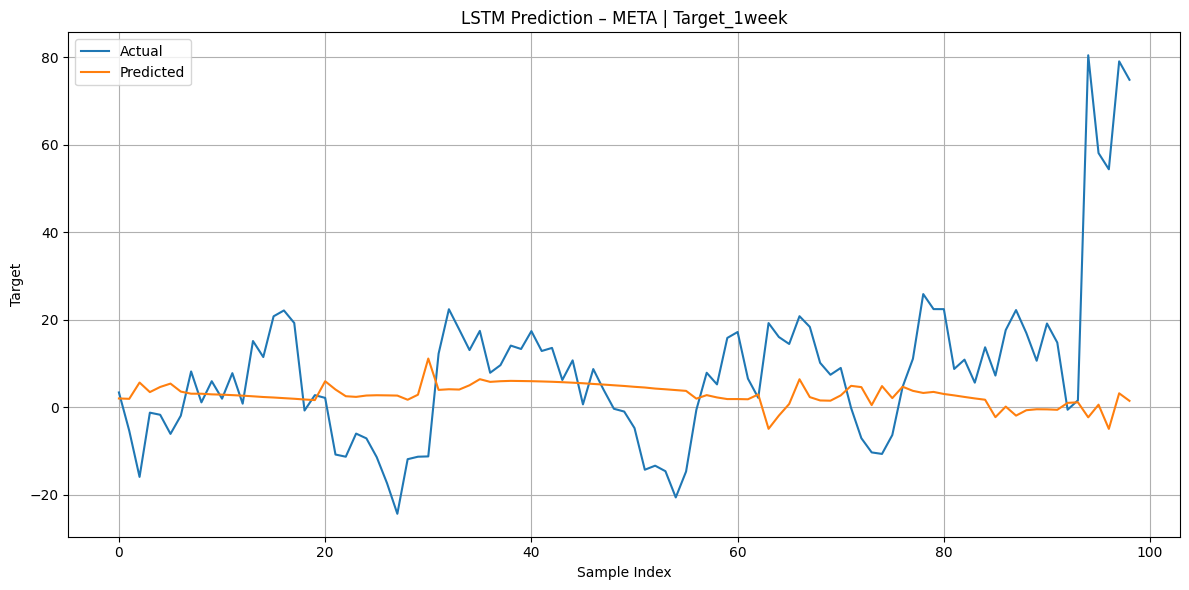

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

[META] Target: Target_1month
MAE : 24.1213
RMSE: 33.0845
R²   : 0.0988


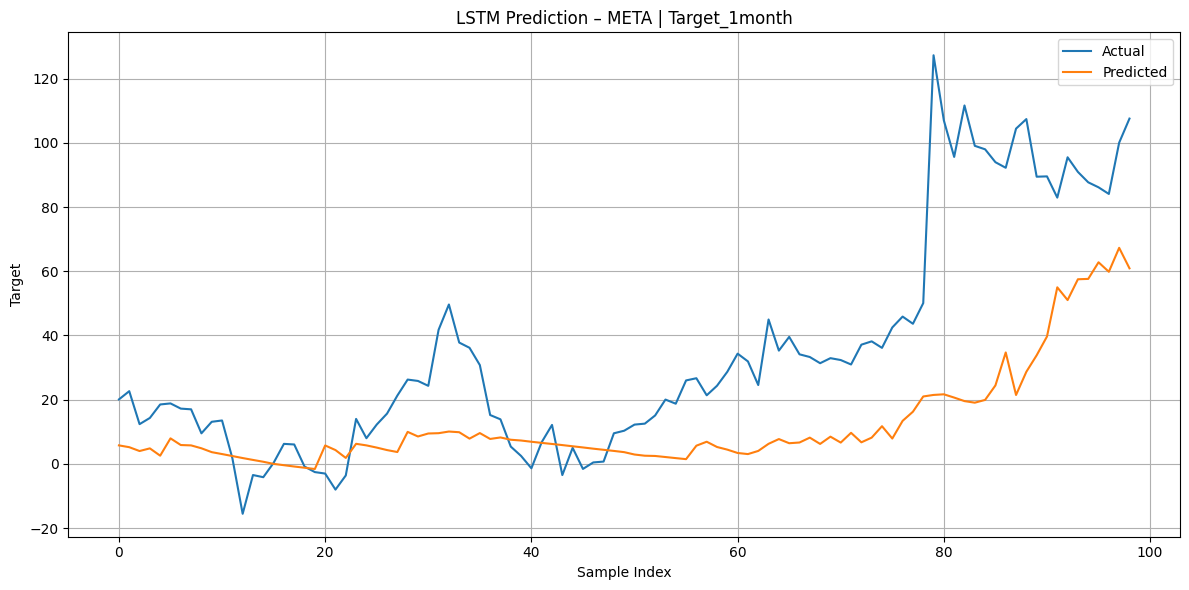

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

[META] Target: Target_1year
MAE : 149.3761
RMSE: 157.1578
R²   : -50.5020


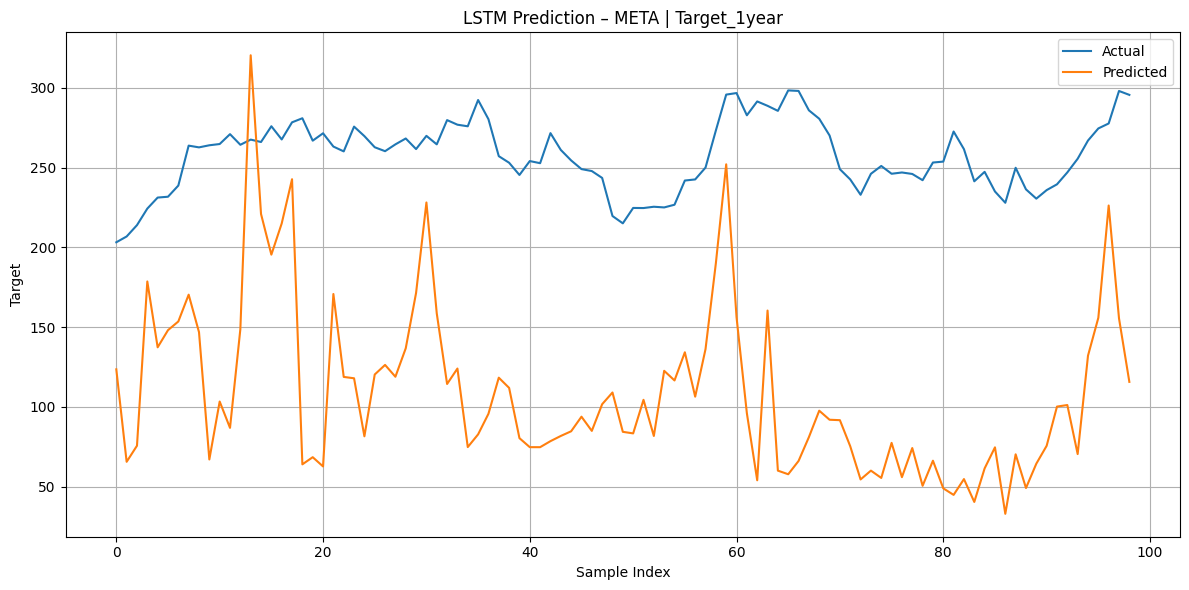

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step

[MSFT] Target: Target_1day
MAE : 14.9432
RMSE: 18.3953
R²   : -18.4106


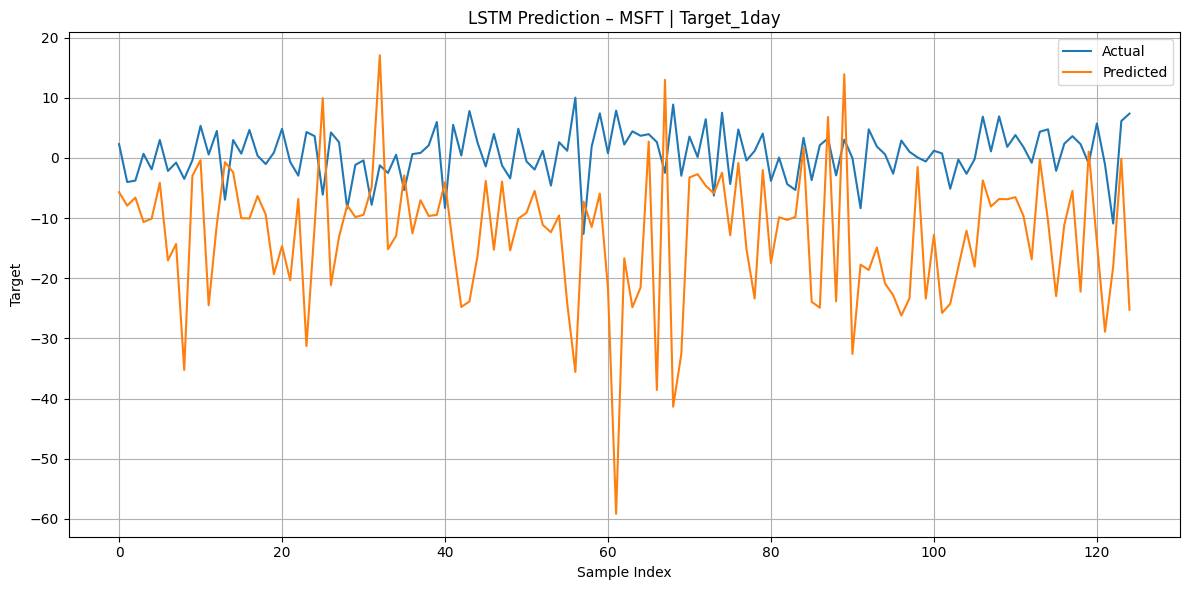

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

[MSFT] Target: Target_1week
MAE : 31.2664
RMSE: 34.5092
R²   : -16.4031


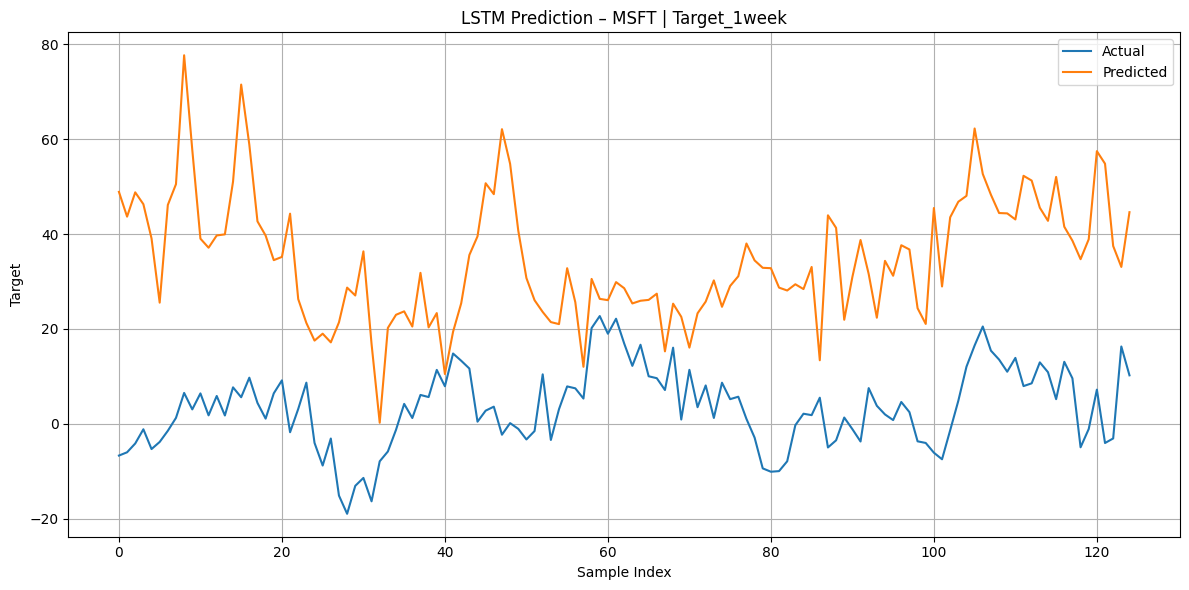

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step

[MSFT] Target: Target_1month
MAE : 161.7552
RMSE: 222.4887
R²   : -174.5019


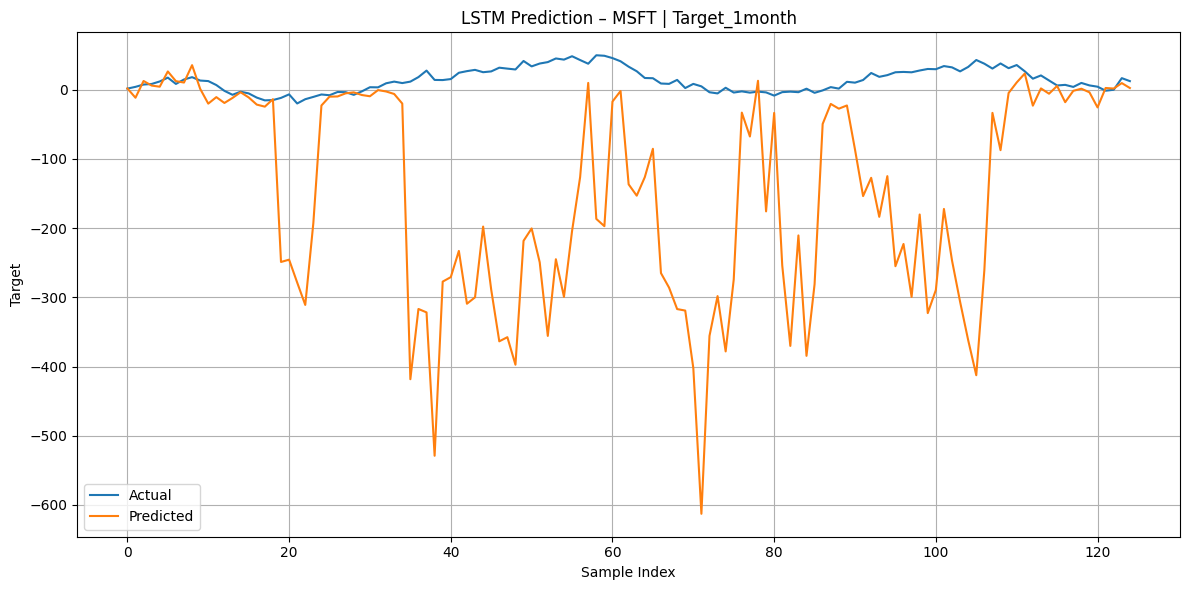

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

[MSFT] Target: Target_1year
MAE : 70.6143
RMSE: 91.7012
R²   : -12.5044


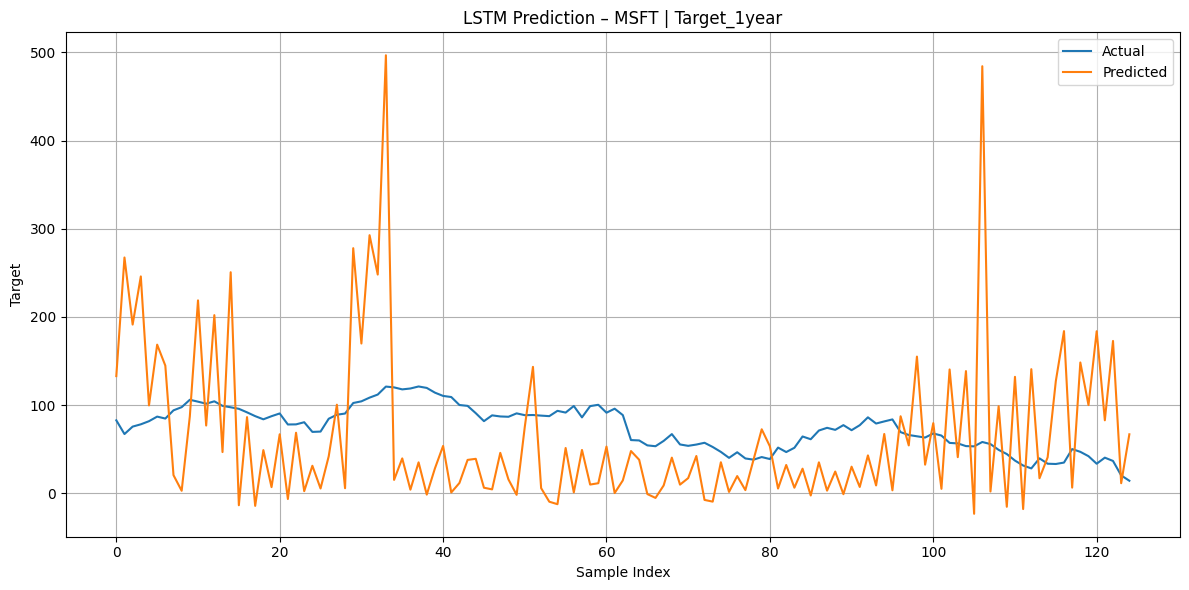

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

[NVDA] Target: Target_1day
MAE : 1.3753
RMSE: 1.9626
R²   : -2.6157


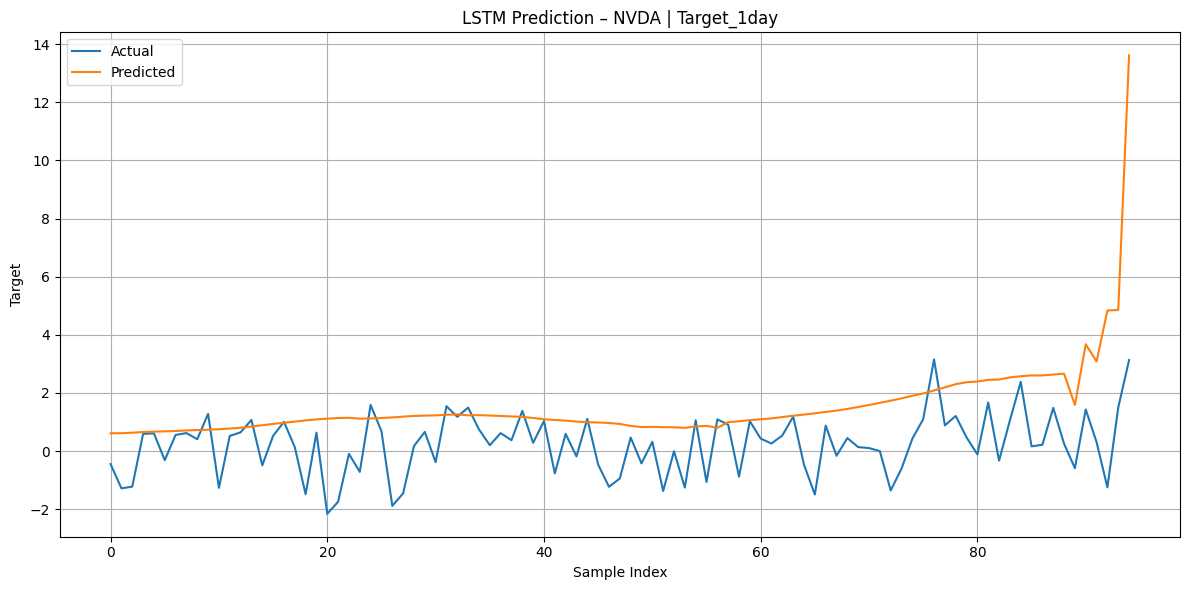

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step

[NVDA] Target: Target_1week
MAE : 2.5236
RMSE: 3.3477
R²   : -0.4596


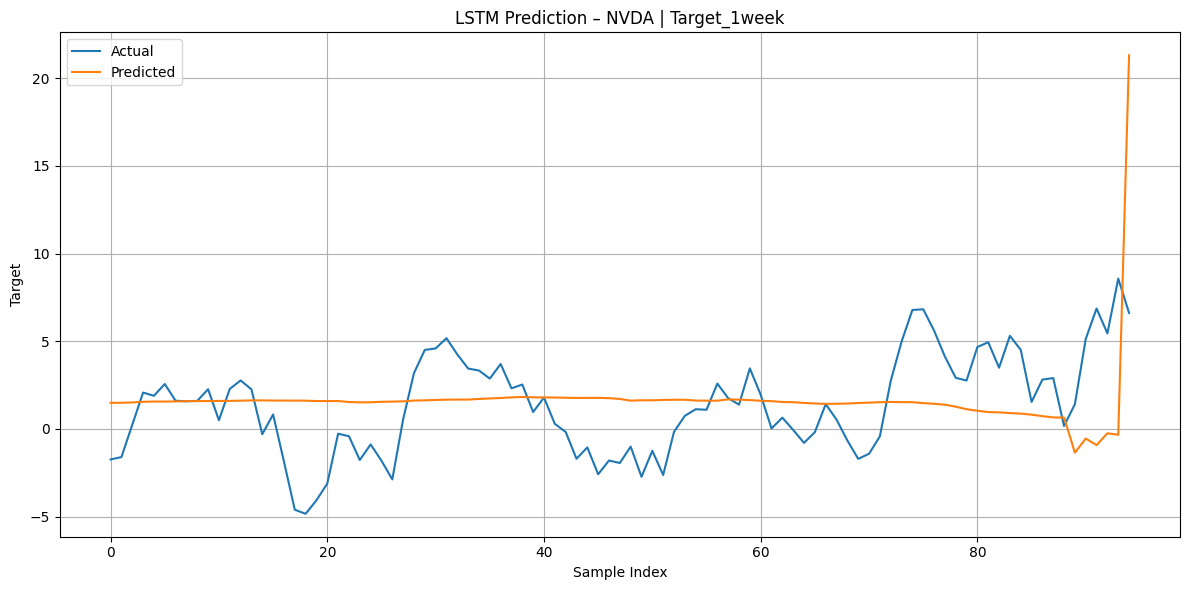

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

[NVDA] Target: Target_1month
MAE : 8.6881
RMSE: 11.0302
R²   : -1.6969


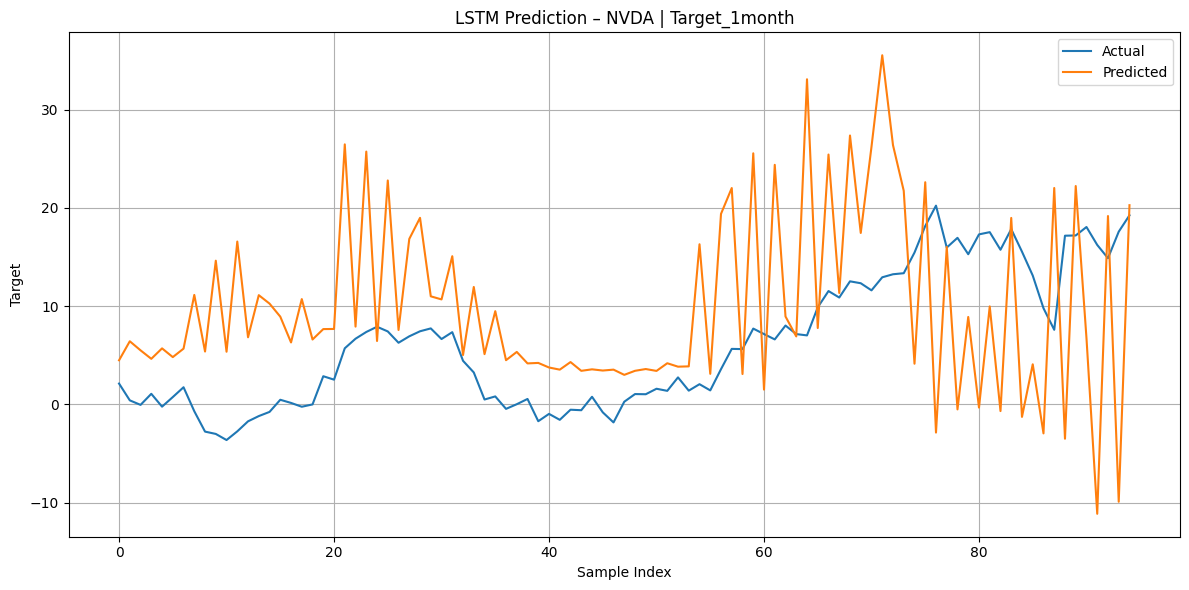

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

[NVDA] Target: Target_1year
MAE : 16.1018
RMSE: 20.9572
R²   : -3.2766


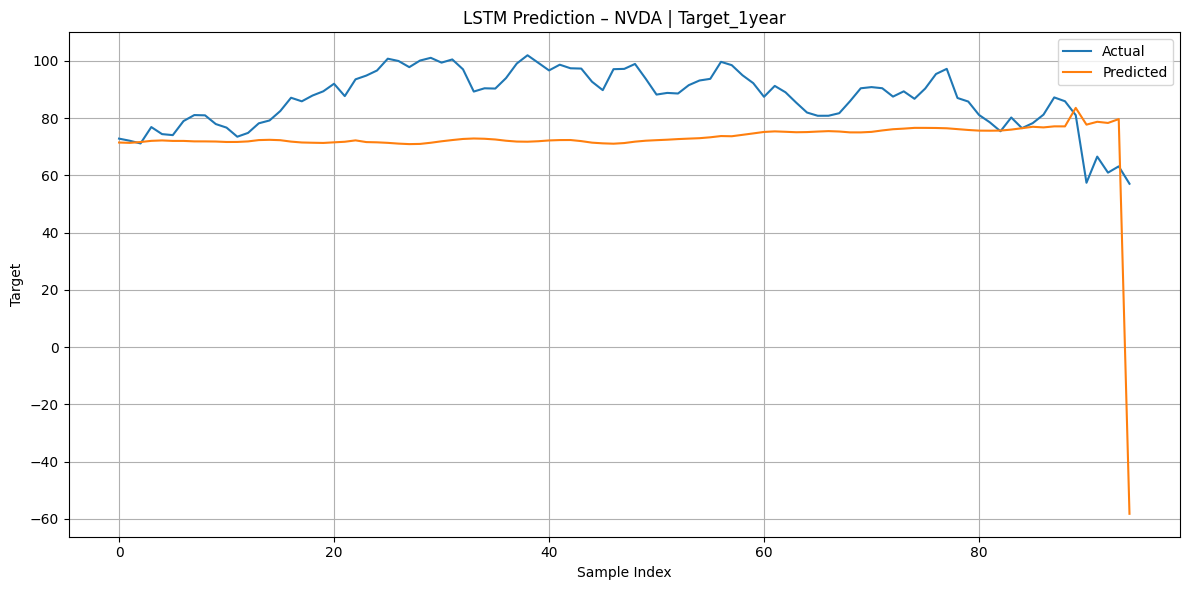

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

[ORCL] Target: Target_1day
MAE : 5.1043
RMSE: 7.6129
R²   : -8.2360


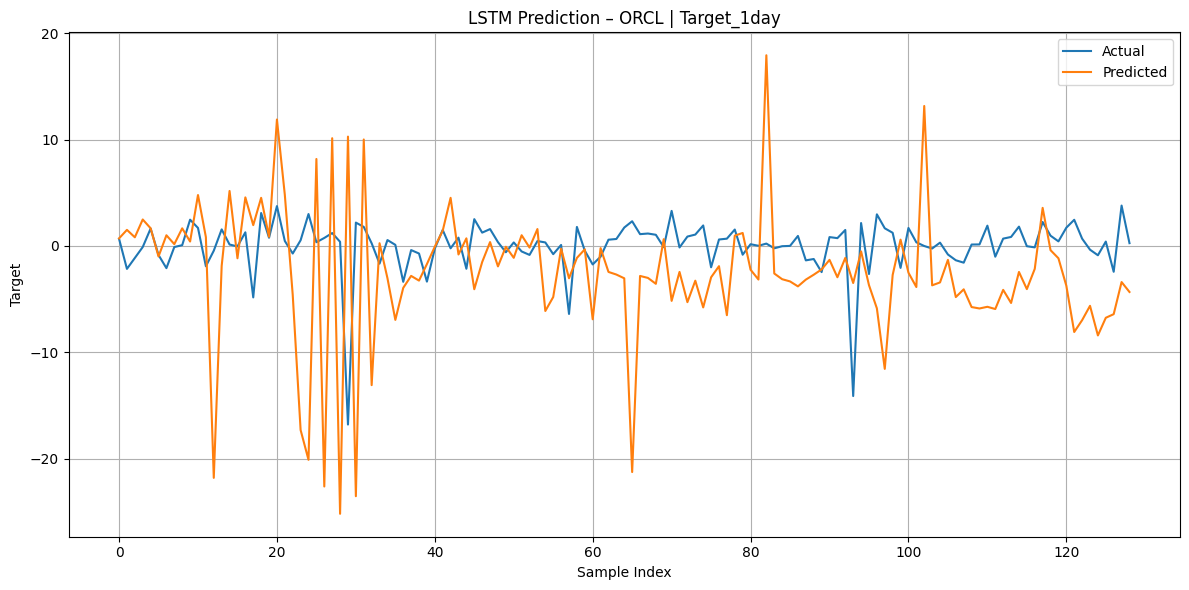

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step

[ORCL] Target: Target_1week
MAE : 35.4068
RMSE: 37.8656
R²   : -58.3684


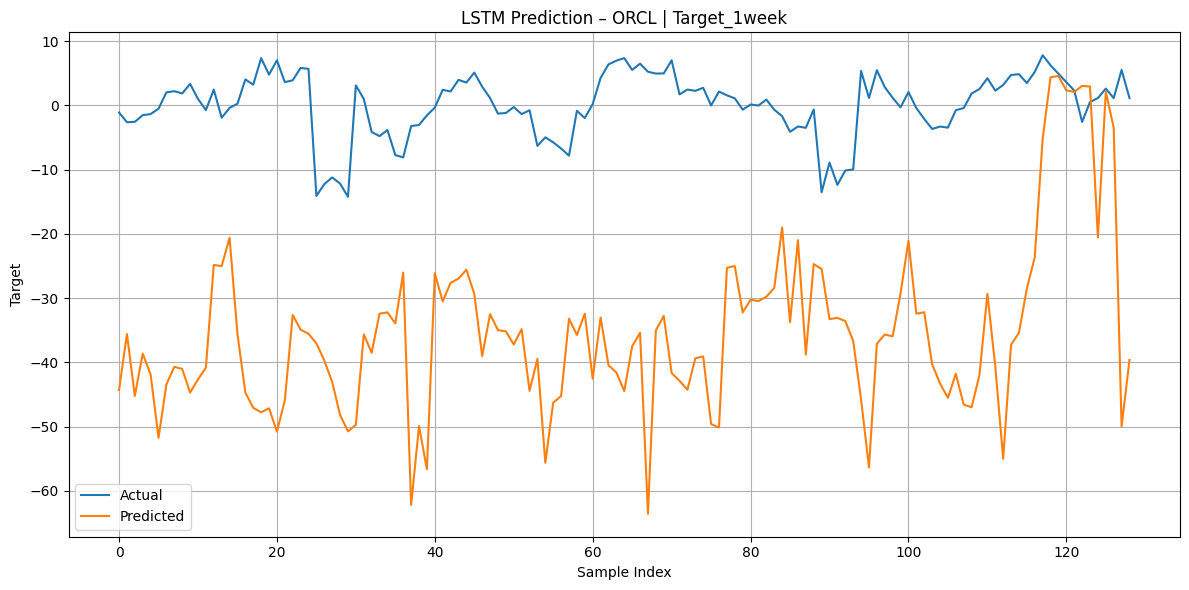

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

[ORCL] Target: Target_1month
MAE : 9.0199
RMSE: 11.4510
R²   : -0.6502


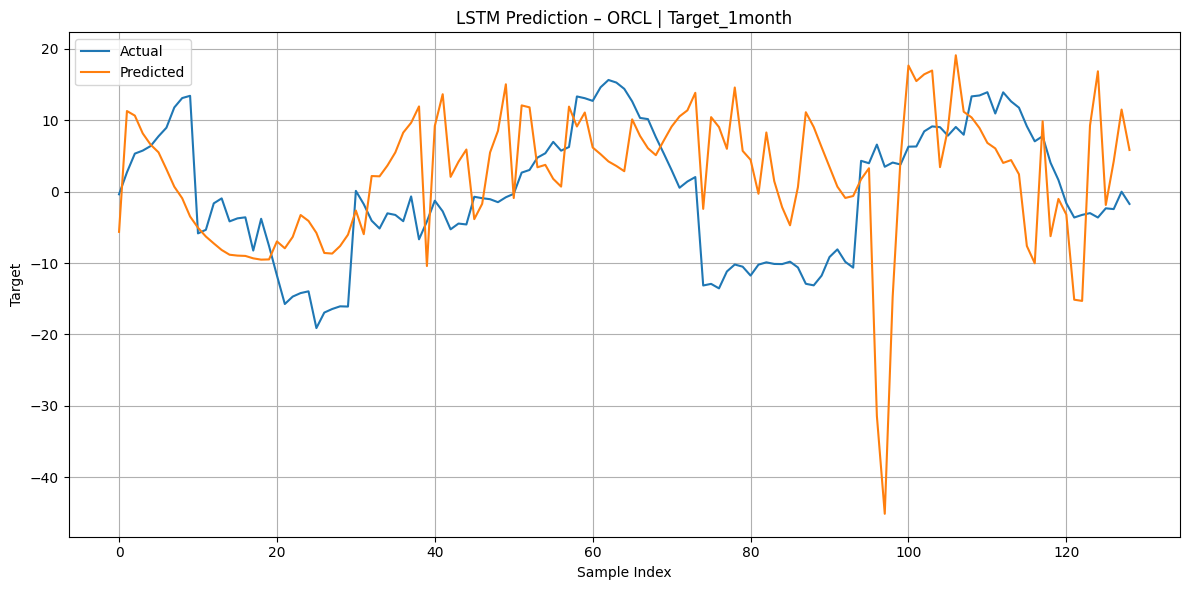

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

[ORCL] Target: Target_1year
MAE : 43.6182
RMSE: 49.1893
R²   : -4.7286


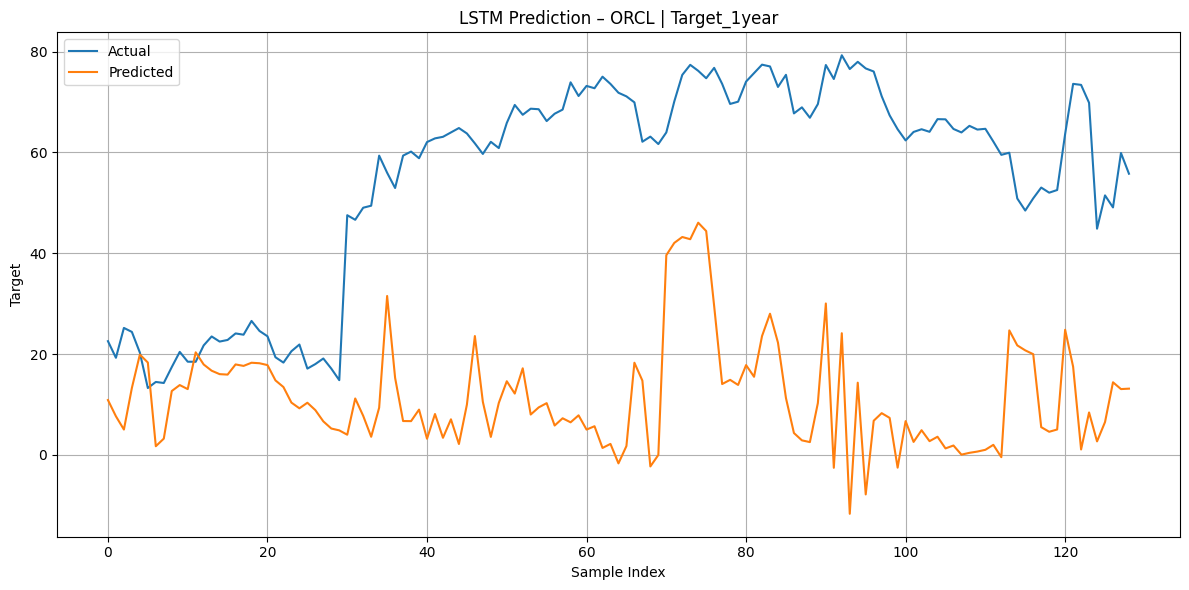

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

[TSLA] Target: Target_1day
MAE : 4.7365
RMSE: 6.6052
R²   : -0.0543


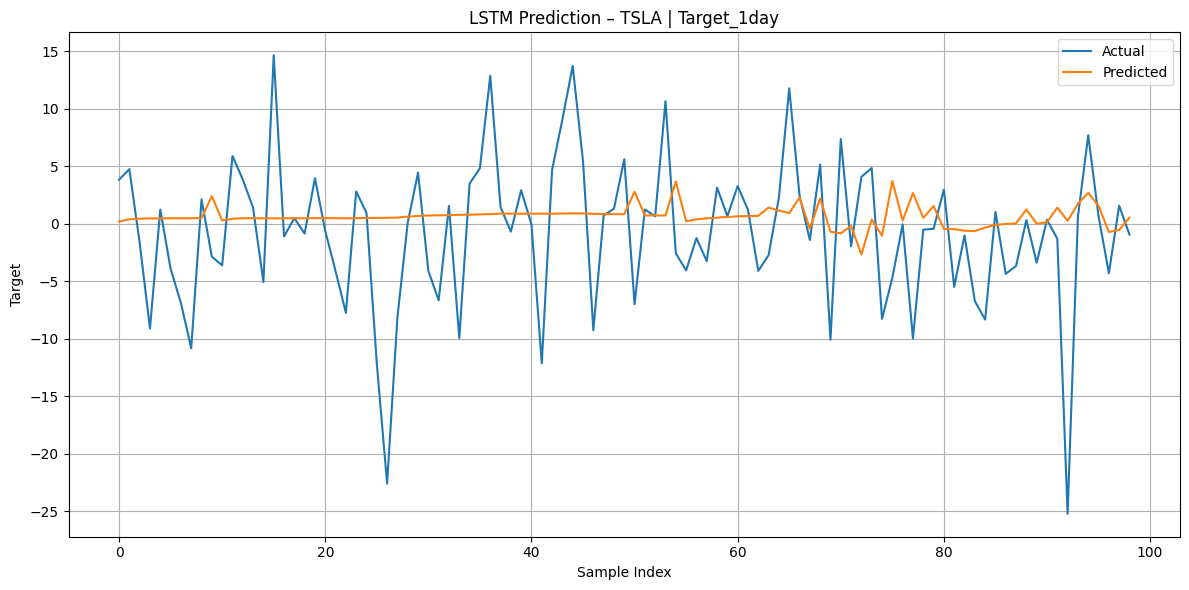

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

[TSLA] Target: Target_1week
MAE : 12.2328
RMSE: 15.7308
R²   : -0.1167


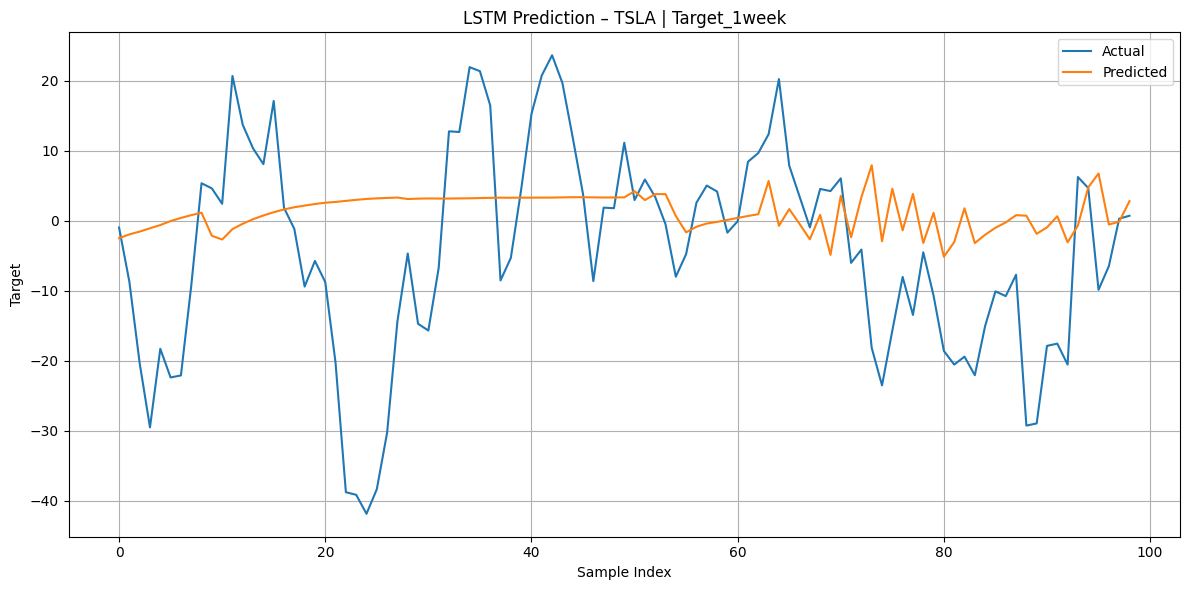

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

[TSLA] Target: Target_1month
MAE : 27.0031
RMSE: 32.6592
R²   : -0.2131


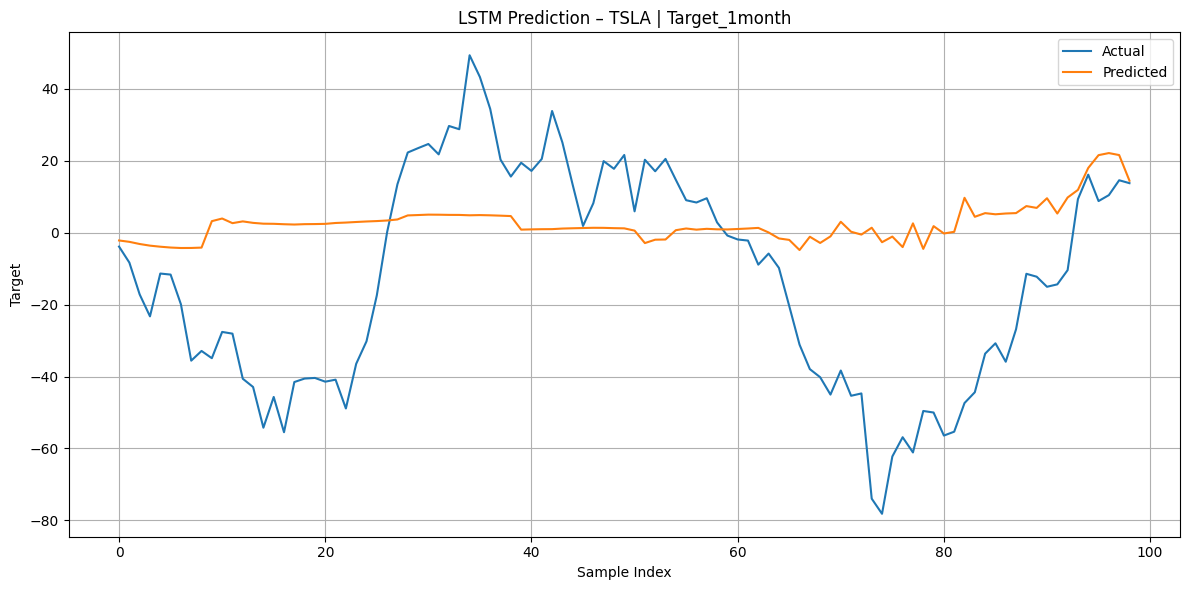

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

[TSLA] Target: Target_1year
MAE : 109.6773
RMSE: 131.5025
R²   : -1.2565


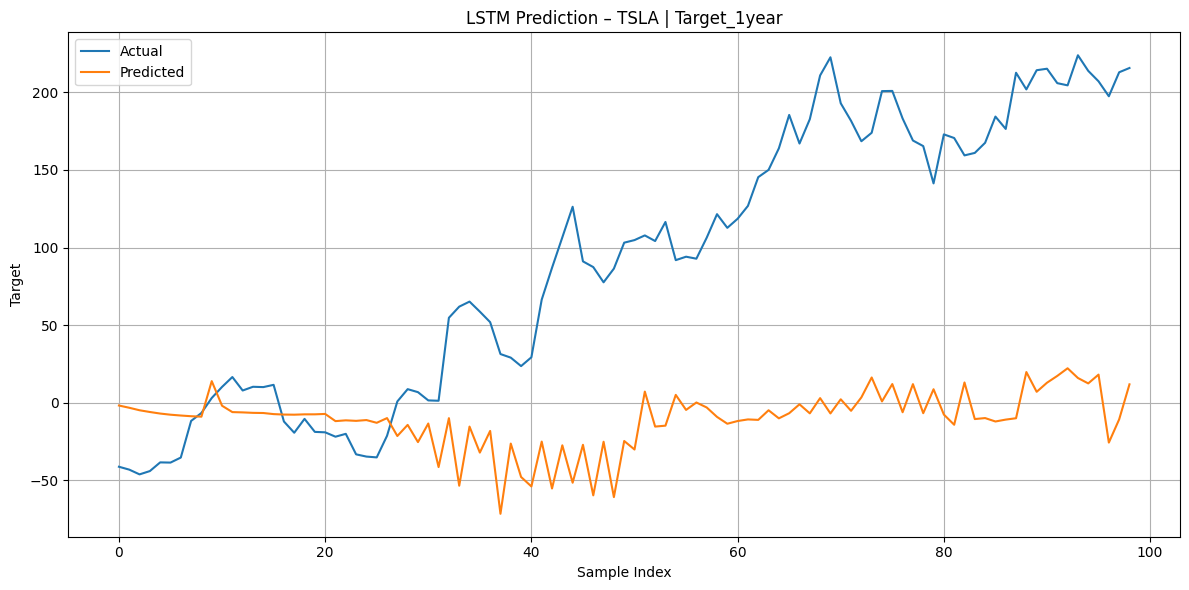

In [12]:
tickers_to_run = df['Ticker'].unique()
targets = ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']

for ticker in tickers_to_run:
    for target in targets:
        run_lstm_by_ticker(df, ticker, target)
